In [11]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pretrainedmodels
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchnet
import torchvision.models
import os
import sys
from torchvision import models as torch_model
#from models import *
sys.path.append("../..")
import backbones.cifar as models
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation

from datasets import Cell_Images
model_names = sorted(name for name in models.__dict__
    if not name.startswith("__")
    and callable(models.__dict__[name]))

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"





from torch.utils.data import Subset

from sklearn.model_selection import train_test_split



evaluate = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)




# Data
print('==> Preparing data..')

transform_test = transforms.Compose([

        #transforms.CenterCrop(672),
        transforms.Resize(224),
        transforms.ToTensor(),

    ])





'''30 cell lines with cross validation'''

selected_cell  = 'LU99'
bs=50
data_path = '/projects/img/cellbank/duplicate_cells2'
data_batch_num = os.listdir(os.path.join(data_path,selected_cell))

label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'



'''Batch 1 is the training set'''

print('Cell Line {} has {} batch data!'.format(selected_cell,len(data_batch_num)))
batch_loader_list = []

for batch_index in list(range(len(data_batch_num)))[:]:
    
    batch_set = Cell_Images(data_path, label_id_path_file, train=True, sup_train=False,
                                            transform=transform_test,selected_cell_data=selected_cell,batch_id = batch_index+1)
    batch_loader = torch.utils.data.DataLoader(batch_set, batch_size=bs, shuffle=False, num_workers=1)
    batch_loader_list.append(batch_loader)
    
    #image_masks.append(batch_set.)





cuda
==> Preparing data..
Cell Line LU99 has 6 batch data!


100%|██████████████████████████████████████████████████████████████████████████| 1872/1872 [02:25<00:00, 12.86it/s]


Cell Batch includes 1 classes with totally 1872 images.


100%|████████████████████████████████████████████████████████████████████████████| 861/861 [01:06<00:00, 12.95it/s]


Cell Batch includes 1 classes with totally 861 images.


100%|██████████████████████████████████████████████████████████████████████████| 1274/1274 [01:36<00:00, 13.21it/s]


Cell Batch includes 1 classes with totally 1274 images.


100%|██████████████████████████████████████████████████████████████████████████| 1785/1785 [02:01<00:00, 14.69it/s]


Cell Batch includes 1 classes with totally 1785 images.


100%|██████████████████████████████████████████████████████████████████████████| 1029/1029 [01:09<00:00, 14.75it/s]


Cell Batch includes 1 classes with totally 1029 images.


100%|██████████████████████████████████████████████████████████████████████████| 1281/1281 [01:32<00:00, 13.79it/s]

Cell Batch includes 1 classes with totally 1281 images.


# Xception with val size 0.2

In [12]:
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
arch = 'Xception'
# resume = './OSR/classification/checkpoints/DATA_WELL_CV/{}_base{}/best_model.pth'.format(arch,10)

resume = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/checkpoints/AZCell/Xception_img_augmented_contrast/best_model.pth'

evaluate = True

train_class_num = 36
# Only for regression

print('==> Building model..')
#ResNet50
if 'ResNet' in arch:

    net = models.__dict__[arch](num_classes=train_class_num,backbone_fc=True,in_channel=3)

elif arch == 'Xception':
    net = models.xception_cla(num_class=train_class_num,input_channel=3)

# mobilenet_v2 vgg19_bn
else:
    net = torch_model.__dict__[arch](pretrained=False, num_classes=train_class_num)

net = net.to(device)

if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
   
criterion = nn.CrossEntropyLoss()



epoch=0
val_loss_pre = 9999999
if not evaluate:

    pass


else:
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    #print(net.module)
    net.eval()

    test_loss = 0
    correct = 0
    total = 0
    #print(net.module)
    feature_net =  torch.nn.Sequential(*(list(net.module.children())[:-1]))
    batch_predict_results,batch_labels,batch_net_features,batch_times =[],[],[],[]
    
    with torch.no_grad():
        for batch_loader in batch_loader_list:
            
            predict_results =[]
            labels = []
            net_features = []
            times=[]
            
            for batch_idx, (inputs,class_labels) in enumerate(batch_loader):
                inputs, class_labels = inputs.cuda(), class_labels.cuda()

                outputs = net(inputs)
                #loss = loss.sum()

                net_feature = feature_net(inputs)
                net_feature= net_feature.view(net_feature.size(0), -1)

                predict_results.append(outputs)
                net_features.append(net_feature)
                labels.append(class_labels)
                progress_bar(batch_idx, len(batch_loader))
    
            labels = np.array(torch.cat(labels,dim=0).cpu().numpy())
            predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())
            net_features = np.array(torch.cat(net_features,dim=0).cpu().numpy())
            
            batch_predict_results.append(predict_results)
            batch_labels.append(labels)
            batch_net_features.append(net_features)





==> Building model..
==> Resuming from checkpoint..
 [===============================================================>.]  Step: 2s472ms | Tot: 47s510ms 38/38 
 [=============================================================>...]  Step: 2s28ms | Tot: 22s249ms 18/18  
 [==============================================================>..]  Step: 2s767ms | Tot: 33s615ms 26/26 
 [===============================================================>.]  Step: 3s80ms | Tot: 46s545ms 36/36  
 [=============================================================>...]  Step: 2s999ms | Tot: 27s304ms 21/21 
 [==============================================================>..]  Step: 3s42ms | Tot: 33s645ms 26/26  


In [13]:
from sklearn.metrics import accuracy_score,f1_score

for batch_idx in range(len(batch_labels)):
    # Batch classification results
    test_predited_labels = batch_predict_results[batch_idx].argmax(axis=1)
    test_accuracy = accuracy_score(batch_labels[batch_idx],test_predited_labels)
    
    print(f"Batch%d %d Images accuracy is %.3f"%(batch_idx+1,len(batch_labels[batch_idx]),test_accuracy)) 
    print('')

Batch1 1872 Images accuracy is 0.975

Batch2 861 Images accuracy is 0.780

Batch3 1274 Images accuracy is 0.005

Batch4 1785 Images accuracy is 0.528

Batch5 1029 Images accuracy is 0.154

Batch6 1281 Images accuracy is 0.336



In [8]:
batch_net_features[0].shape

(4056, 2048)

In [14]:
import numpy as np

store_dir_path  = './outputs'

np.save(store_dir_path+'/{}_features.npy'.format(selected_cell),batch_net_features)



In [11]:
from sklearn.metrics import accuracy_score,f1_score

test_predited_labels = predict_results.argmax(axis=1)
test_accuracy = accuracy_score(labels,test_predited_labels)
test_f1_macro = f1_score(labels,test_predited_labels,average='macro')
print(f"%s accuracy is %.3f,f1_score is %.3f"%(arch,test_accuracy,test_f1_macro))

Xception accuracy is 0.884,f1_score is 0.156


In [113]:
import numpy as np

store_dir_path  = './np_save/A549/'+'batch_4'

if not os.path.isdir(store_dir_path):
    os.mkdir(store_dir_path)

np.save(store_dir_path+'/labels.npy',labels)
np.save(store_dir_path+'/results.npy',predict_results)
np.save(store_dir_path+'/features.npy',plot_features)
np.save(store_dir_path+'/times.npy',batch4_set.label_times)


In [11]:
import numpy as np
folder_name = resume.split('/')[-2]
store_dir_path  = './numpy_array2/'+folder_name+'_base10'

if not os.path.isdir(store_dir_path):
    os.mkdir(store_dir_path)

np.save(store_dir_path+'/test_labels.npy',labels)
np.save(store_dir_path+'/test_results.npy',predict_results)
np.save(store_dir_path+'/test_features.npy',plot_features)
np.save(store_dir_path+'/test_times.npy',times)


In [69]:
'''Training data here'''

net.eval()

test_loss = 0
correct = 0
total = 0
#print(net.module)
train_predict_results =[]
train_labels = []
train_net_features = []
train_times = []
with torch.no_grad():
    for batch_idx, (inputs, (class_labels, time_points)) in enumerate(train_trainloader):
        inputs, class_labels, time_points = inputs.to(device), class_labels.to(device), time_points.to(device)

        outputs = net(inputs)

        _, predicted = outputs.max(1)
        net_feature = feature_net(inputs)
        net_feature=net_feature.view(net_feature.size(0), -1)
            
            
        
            
        train_times.append(time_points)
        train_net_features.append(net_feature)
        train_predict_results.append(predicted)
        
        train_labels.append(class_labels)
        progress_bar(batch_idx, len(train_trainloader))


train_labels = torch.cat(train_labels,dim=0).cpu().numpy()

train_labels = np.array(train_labels)
train_predict_results = np.array(torch.cat(train_predict_results,dim=0).cpu().numpy())
train_plot_features = np.array(torch.cat(train_net_features, dim=0).cpu().numpy())

train_times= np.array(torch.cat(train_times, dim=0).cpu().numpy())




 [================================================================>]  Step: 1s539ms | Tot: 20m4s 2351/2351  


In [71]:
import numpy as np
store_dir_path  = './numpy_array3/'
np.save(store_dir_path+'/train_labels.npy',train_labels)
np.save(store_dir_path+'/train_results.npy',train_predict_results)
np.save(store_dir_path+'/train_features.npy',train_plot_features)
np.save(store_dir_path+'/train_times.npy',train_times)

In [82]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
reg_model = LinearRegression().fit(train_plot_features,train_times*15.5)

reg_predicted_times = reg_model.predict(plot_features)
reg_train_predicted_time = reg_model.predict(train_plot_features)
print("train MSE = {}, test MSE = {}".format(mean_squared_error(reg_train_predicted_time,train_times*15.5),
                                             
                                            mean_squared_error(reg_predicted_times,times*15.5)))

train MSE = 2.9122723044669183e-07, test MSE = 0.804065391740628


# Patch Classification

In [2]:

from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pretrainedmodels
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchnet
import torchvision.models
import os
import argparse
import sys
from torchvision import models as torch_model
#from models import *
sys.path.append("../..")
import backbones.cifar as models
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation

from datasets import Cell_masked_patches
model_names = sorted(name for name in models.__dict__
    if not name.startswith("__")
    and callable(models.__dict__[name]))

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"





from torch.utils.data import Subset

from sklearn.model_selection import train_test_split



evaluate = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)




# Data
print('==> Preparing data..')

transform_test = transforms.Compose([
        transforms.ToTensor(),
        
    ])




'''30 cell lines with cross validation'''

selected_cell  = 'CAMA1'
bs=50
#full_data_path = '/projects/img/cellbank/duplicate_cells'
full_data_path = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data/'
data_batch_num = os.listdir(os.path.join(full_data_path,selected_cell))
#mask_data_path = '/projects/img/cellbank/duplicate_cells_masks'
mask_data_path = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask/'
label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'

patch_size = (224,224)
cell_area_threshold = 0.10

'''Batch 1 is the training set'''

print('Cell Line {} has {} batch data!'.format(selected_cell,len(data_batch_num)))
batch_loader_list = []
image_tokens  = [] 
image_masks = [] 
confluencys =  []
for batch_index in list(range(len(data_batch_num)))[1:]:
    # change batch_id 
    batch_set = Cell_masked_patches(full_data_path, mask_data_path,label_id_path_file, train=False, transform_aug=transform_test
                              , shuffle=False, batch_ids=batch_index+1, remove_times=24,
                                    selected_cell_data=selected_cell,patch_size=patch_size,cell_area_threshold=cell_area_threshold)
    batch_set.load_data()
    batch_loader = torch.utils.data.DataLoader(batch_set, batch_size=bs, shuffle=False, num_workers=1)
    batch_loader_list.append(batch_loader)
    image_tokens.append(batch_set.unique_image_tokens)
    confluencys.append(batch_set.confluency)
    #image_masks.append(batch_set.)



cuda
==> Preparing data..
Cell Line CAMA1 has 5 batch data!


100%|█████████████████████████████████████████████████████████████████████████████████| 94/94 [00:02<00:00, 36.23it/s]


Cell Batch 2 includes 1 classes with totally 1410 images.


100%|█████████████████████████████████████████████████████████████████████████████| 4914/4914 [04:13<00:00, 19.37it/s]


Cell Batch 3 includes 1 classes with totally 69334 images.


100%|█████████████████████████████████████████████████████████████████████████████| 3969/3969 [03:17<00:00, 20.11it/s]


Cell Batch 4 includes 1 classes with totally 49573 images.


100%|█████████████████████████████████████████████████████████████████████████████| 2772/2772 [02:18<00:00, 20.05it/s]


Cell Batch 5 includes 1 classes with totally 37217 images.


In [3]:

class FullModel(nn.Module):
    def __init__(self, model, loss):
        super(FullModel, self).__init__()
        self.model = model
        self.loss = loss

    def forward(self, targets, *inputs):
        outputs = self.model(*inputs)
        loss = self.loss(outputs, targets)
        return torch.unsqueeze(loss, 0), outputs


def DataParallel_withLoss(model, loss=None, **kwargs):
    model = FullModel(model, loss)
    if 'device_ids' in kwargs.keys():
        device_ids = kwargs['device_ids']
    else:
        device_ids = None
    if 'output_device' in kwargs.keys():
        output_device = kwargs['output_device']
    else:
        output_device = None
    if 'cuda' in kwargs.keys():
        cudaID = kwargs['cuda']
        model = torch.nn.DataParallel(model, device_ids=device_ids, output_device=output_device).cuda(cudaID)
    else:
        print('Multiple GPU {}.'.format(device_ids))
        model = torch.nn.DataParallel(model, device_ids=device_ids, output_device=output_device).cuda()
    return model


In [4]:
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
from Utils import utils
arch = 'Xception'
# resume = './OSR/classification/checkpoints/DATA_WELL_CV/{}_base{}/best_model.pth'.format(arch,10)

resume = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/checkpoints_patch/AZCell/Xception_patch224_area0.1_enhanced_auged_200/last_model.pth'

evaluate = True

train_class_num = 35
# Only for regression

print('==> Building model..')
#ResNet50
if 'ResNet' in arch:

    net = models.__dict__[arch](num_classes=train_class_num,backbone_fc=True,in_channel=3)

elif arch == 'Xception':
    net = models.xception_cla(num_class=train_class_num,input_channel=3)

# mobilenet_v2 vgg19_bn
else:
    net = torch_model.__dict__[arch](pretrained=False, num_classes=train_class_num)

criterion = nn.CrossEntropyLoss()
if device == 'cuda':
    #net = torch.nn.DataParallel(net)
    net = DataParallel_withLoss(net,criterion,device_ids=list(range(torch.cuda.device_count())),output_device=0)
    cudnn.benchmark = True
net = net.module
if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
        
        
        

   

epoch=0
val_loss_pre = 9999999
if not evaluate:
    pass
else:
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    
    #print(net.module)
    # each list contain multiple batch data 
    
    feature_net =  torch.nn.Sequential(*(list(net.children())[:-1]))
    batch_predict_results,batch_labels,batch_net_features,batch_times =[],[],[],[]

    with torch.no_grad():
        for batch_loader in batch_loader_list:
            
            predict_results =[]
            labels = []
            net_features = []
            times=[]
            
            for batch_idx, (inputs,class_labels) in enumerate(batch_loader):
                inputs, class_labels = inputs.cuda(), class_labels.cuda()

                _, outputs = net(class_labels,inputs)
                #outputs = net(inputs)

                net_feature = feature_net(inputs)
                net_feature= net_feature.view(net_feature.size(0), -1)

                predict_results.append(outputs)
                net_features.append(net_feature)
                labels.append(class_labels)
                progress_bar(batch_idx, len(batch_loader))
    
            labels = np.array(torch.cat(labels,dim=0).cpu().numpy())
            predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())
            
            batch_predict_results.append(predict_results)
            batch_labels.append(labels)
            # plot_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
            #     times = np.array(torch.cat(times,dim=0).cpu().numpy())



==> Building model..
Multiple GPU [0].
==> Resuming from checkpoint..
 [==============================================================>..]  Step: 3s212ms | Tot: 36s496ms 29/29 
 [================================================================>]  Step: 4s117ms | Tot: 29m16s 1387/1387   
 [================================================================>]  Step: 4s184ms | Tot: 20m55s 992/992 2 
 [================================================================>]  Step: 3s852ms | Tot: 15m42s 745/745 5 


In [5]:
# # Save CAMA1 numpy_data
# import numpy as np 
# np.save('/projects/img/cellbank/Cell_Batch_Classification/np_results/CAMA1/batch_labels.npy',batch_labels)
# np.save('/projects/img/cellbank/Cell_Batch_Classification/np_results/CAMA1/batch_predict_results.npy',batch_predict_results)
# np.save('/projects/img/cellbank/Cell_Batch_Classification/np_results/CAMA1/image_tokens.npy',image_tokens)

In [6]:
# for batch_idx in range(len(batch_labels)):
#     # Batch classification results
#     test_predited_labels = batch_predict_results[batch_idx].argmax(axis=1)
#     print('Batch{} bincount: {}'.format(batch_idx+2,np.bincount(test_predited_labels)))

In [7]:
from sklearn.metrics import accuracy_score,f1_score

for batch_idx in range(len(batch_labels)):
    # Batch classification results
    test_predited_labels = batch_predict_results[batch_idx].argmax(axis=1)
    test_accuracy = accuracy_score(batch_labels[batch_idx],test_predited_labels)
    test_f1_macro = f1_score(batch_labels[batch_idx],test_predited_labels,average='macro')
    print(f"Batch%d %d Patches accuracy is %.3f"%(batch_idx+1,len(batch_labels[batch_idx]),test_accuracy))
    # image level results 
    batch_image_token = np.unique(image_tokens[batch_idx])
    img_Pred_results, img_GT = [],[]
    for img_id in batch_image_token:
        imgs_ids = np.where(image_tokens[batch_idx] == img_id)
        img_predicted_labels,img_labels =  test_predited_labels[imgs_ids],batch_labels[batch_idx][imgs_ids]
        img_predicted_labels,img_labels = np.argmax(np.bincount(img_predicted_labels)),np.argmax(np.bincount(img_labels))
        img_Pred_results.append(img_predicted_labels)
        img_GT.append(img_labels)
        
    test_accuracy = accuracy_score(img_Pred_results, img_GT)
    test_f1_macro = f1_score(img_Pred_results, img_GT,average='macro')
    print(f"Batch%d %d Images accuracy is %.3f"%(batch_idx+1,len(img_GT),test_accuracy))  
    print('')

Batch1 1410 Patches accuracy is 0.914
Batch1 94 Images accuracy is 0.968

Batch2 69334 Patches accuracy is 0.298
Batch2 4914 Images accuracy is 0.264

Batch3 49573 Patches accuracy is 0.263
Batch3 3969 Images accuracy is 0.232

Batch4 37217 Patches accuracy is 0.627
Batch4 2772 Images accuracy is 0.745



In [8]:
from sklearn.metrics import accuracy_score,f1_score,top_k_accuracy_score
print('Cell line {}'.format(selected_cell))
for batch_idx in range(len(batch_labels)):
    # Batch classification results
    test_predited_labels = batch_predict_results[batch_idx].argmax(axis=1)
    test_accuracy = accuracy_score(batch_labels[batch_idx],test_predited_labels)
    
    test_top_3_acc = top_k_accuracy_score(batch_labels[batch_idx],batch_predict_results[batch_idx],k=3,labels=range(train_class_num))
    test_top_5_acc = top_k_accuracy_score(batch_labels[batch_idx],batch_predict_results[batch_idx],k=5,labels=range(train_class_num))
    print(f"Batch%d %d Patches accuracy is %.3f"%(batch_idx+1,len(batch_labels[batch_idx]),test_accuracy))
    print(f"Batch%d Patches top3_acc=%.3f, top5_acc=%.3f"%(batch_idx+1,test_top_3_acc,test_top_5_acc))
    # image level results 
    batch_image_token = np.unique(image_tokens[batch_idx])
    img_Pred_results, img_GT = [],[]
    img_Pred_prob = []
    for img_id in batch_image_token:
        imgs_ids = np.where(image_tokens[batch_idx] == img_id)
        img_predicted_labels,img_labels =  test_predited_labels[imgs_ids],batch_labels[batch_idx][imgs_ids]
        
        img_predicted_labels,img_labels = np.argmax(np.bincount(img_predicted_labels)),np.argmax(np.bincount(img_labels))
        
        img_Pred_results.append(img_predicted_labels)
        img_GT.append(img_labels)
        
    test_accuracy = accuracy_score(img_Pred_results, img_GT)
    # test_top_3_acc = top_k_accuracy_score(img_Pred_prob, img_GT,k=3,labels=range(31))
    # test_top_5_acc = top_k_accuracy_score(img_Pred_prob, img_GT,k=5,labels=range(31))
    print(f"Batch%d %d Images accuracy is %.3f"%(batch_idx+1,len(img_GT),test_accuracy))  
    #print(f"Batch%d Images top3_acc=%.3f, top5_acc=%.3f"%(batch_idx+1,test_top_3_acc,test_top_5_acc))
    
    print('')

Cell line CAMA1
Batch1 1410 Patches accuracy is 0.914
Batch1 Patches top3_acc=1.000, top5_acc=1.000
Batch1 94 Images accuracy is 0.968

Batch2 69334 Patches accuracy is 0.298
Batch2 Patches top3_acc=0.906, top5_acc=0.990
Batch2 4914 Images accuracy is 0.264

Batch3 49573 Patches accuracy is 0.263
Batch3 Patches top3_acc=0.857, top5_acc=0.975
Batch3 3969 Images accuracy is 0.232

Batch4 37217 Patches accuracy is 0.627
Batch4 Patches top3_acc=0.841, top5_acc=0.935
Batch4 2772 Images accuracy is 0.745



In [113]:
# # Save  numpy_data
import numpy as np 
import os 
save_root_path = '/projects/img/cellbank/Cell_Batch_Classification/output/'

if not os.path.isdir(os.path.join(save_root_path,selected_cell)) :
    os.mkdir(os.path.join(save_root_path,selected_cell))
    
save_root_path = os.path.join(save_root_path,selected_cell)
np.save(os.path.join(save_root_path,'batch_predict_results'),batch_predict_results)
np.save(os.path.join(save_root_path,'batch_labels'),batch_labels)
np.save(os.path.join(save_root_path,'image_tokens'),image_tokens)
np.save(os.path.join(save_root_path,'confluencys'),confluencys)
print('numpy data saved')


numpy data saved


In [8]:
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
from Utils import utils
arch = 'Xception'
# resume = './OSR/classification/checkpoints/DATA_WELL_CV/{}_base{}/best_model.pth'.format(arch,10)

resume = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/checkpoints_patch/AZCell/Xception_crop224_patch28_False/best_model.pth'

evaluate = True

train_class_num = 31
# Only for regression

print('==> Building model..')
#ResNet50
if 'ResNet' in arch:

    net = models.__dict__[arch](num_classes=train_class_num,backbone_fc=True,in_channel=3)

elif arch == 'Xception':
    net = models.xception_cla(num_class=train_class_num,input_channel=3)

# mobilenet_v2 vgg19_bn
else:
    net = torch_model.__dict__[arch](pretrained=False, num_classes=train_class_num)

criterion = nn.CrossEntropyLoss()
if device == 'cuda':
    net = utils.DataParallel_withLoss(net,criterion,device_ids=list(range(torch.cuda.device_count())),output_device=0)
    cudnn.benchmark = True

if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
   

epoch=0
val_loss_pre = 9999999
if not evaluate:
    pass
else:
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    
    #print(net.module)
    # each list contain multiple batch data 
    
    feature_net =  torch.nn.Sequential(*(list(net.module.children())[:-1]))
    batch_predict_results,batch_labels,batch_net_features,batch_times =[],[],[],[]

    with torch.no_grad():
        for batch_loader in batch_loader_list:
            
            predict_results =[]
            labels = []
            net_features = []
            times=[]
            
            for batch_idx, (inputs,class_labels) in enumerate(batch_loader):
                inputs, class_labels = inputs.cuda(), class_labels.cuda()

                loss, outputs = net(inputs)
                #loss = loss.sum()

                net_feature = feature_net(inputs)
                net_feature= net_feature.view(net_feature.size(0), -1)

                predict_results.append(outputs)
                net_features.append(net_feature)
                labels.append(class_labels)
                progress_bar(batch_idx, len(batch_loader))
    
            labels = np.array(torch.cat(labels,dim=0).cpu().numpy())
            predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())
            
            batch_predict_results.append(predict_results)
            batch_labels.append(labels)
            # plot_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
            #     times = np.array(torch.cat(times,dim=0).cpu().numpy())





==> Building model..
Multiple GPU [0, 1].
==> Resuming from checkpoint..


RuntimeError: Error(s) in loading state_dict for DataParallel:
	Missing key(s) in state_dict: "module.model.entry_flow.conv1.0.weight", "module.model.entry_flow.conv1.1.weight", "module.model.entry_flow.conv1.1.bias", "module.model.entry_flow.conv1.1.running_mean", "module.model.entry_flow.conv1.1.running_var", "module.model.entry_flow.conv2.0.weight", "module.model.entry_flow.conv2.1.weight", "module.model.entry_flow.conv2.1.bias", "module.model.entry_flow.conv2.1.running_mean", "module.model.entry_flow.conv2.1.running_var", "module.model.entry_flow.conv3_residual.0.depthwise.weight", "module.model.entry_flow.conv3_residual.0.pointwise.weight", "module.model.entry_flow.conv3_residual.1.weight", "module.model.entry_flow.conv3_residual.1.bias", "module.model.entry_flow.conv3_residual.1.running_mean", "module.model.entry_flow.conv3_residual.1.running_var", "module.model.entry_flow.conv3_residual.3.depthwise.weight", "module.model.entry_flow.conv3_residual.3.pointwise.weight", "module.model.entry_flow.conv3_residual.4.weight", "module.model.entry_flow.conv3_residual.4.bias", "module.model.entry_flow.conv3_residual.4.running_mean", "module.model.entry_flow.conv3_residual.4.running_var", "module.model.entry_flow.conv3_shortcut.0.weight", "module.model.entry_flow.conv3_shortcut.0.bias", "module.model.entry_flow.conv3_shortcut.1.weight", "module.model.entry_flow.conv3_shortcut.1.bias", "module.model.entry_flow.conv3_shortcut.1.running_mean", "module.model.entry_flow.conv3_shortcut.1.running_var", "module.model.entry_flow.conv4_residual.1.depthwise.weight", "module.model.entry_flow.conv4_residual.1.pointwise.weight", "module.model.entry_flow.conv4_residual.2.weight", "module.model.entry_flow.conv4_residual.2.bias", "module.model.entry_flow.conv4_residual.2.running_mean", "module.model.entry_flow.conv4_residual.2.running_var", "module.model.entry_flow.conv4_residual.4.depthwise.weight", "module.model.entry_flow.conv4_residual.4.pointwise.weight", "module.model.entry_flow.conv4_residual.5.weight", "module.model.entry_flow.conv4_residual.5.bias", "module.model.entry_flow.conv4_residual.5.running_mean", "module.model.entry_flow.conv4_residual.5.running_var", "module.model.entry_flow.conv4_shortcut.0.weight", "module.model.entry_flow.conv4_shortcut.0.bias", "module.model.entry_flow.conv4_shortcut.1.weight", "module.model.entry_flow.conv4_shortcut.1.bias", "module.model.entry_flow.conv4_shortcut.1.running_mean", "module.model.entry_flow.conv4_shortcut.1.running_var", "module.model.entry_flow.conv5_residual.1.depthwise.weight", "module.model.entry_flow.conv5_residual.1.pointwise.weight", "module.model.entry_flow.conv5_residual.2.weight", "module.model.entry_flow.conv5_residual.2.bias", "module.model.entry_flow.conv5_residual.2.running_mean", "module.model.entry_flow.conv5_residual.2.running_var", "module.model.entry_flow.conv5_residual.4.depthwise.weight", "module.model.entry_flow.conv5_residual.4.pointwise.weight", "module.model.entry_flow.conv5_residual.5.weight", "module.model.entry_flow.conv5_residual.5.bias", "module.model.entry_flow.conv5_residual.5.running_mean", "module.model.entry_flow.conv5_residual.5.running_var", "module.model.entry_flow.conv5_shortcut.0.weight", "module.model.entry_flow.conv5_shortcut.0.bias", "module.model.entry_flow.conv5_shortcut.1.weight", "module.model.entry_flow.conv5_shortcut.1.bias", "module.model.entry_flow.conv5_shortcut.1.running_mean", "module.model.entry_flow.conv5_shortcut.1.running_var", "module.model.middel_flow.middel_block.0.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.0.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.0.conv1.2.weight", "module.model.middel_flow.middel_block.0.conv1.2.bias", "module.model.middel_flow.middel_block.0.conv1.2.running_mean", "module.model.middel_flow.middel_block.0.conv1.2.running_var", "module.model.middel_flow.middel_block.0.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.0.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.0.conv2.2.weight", "module.model.middel_flow.middel_block.0.conv2.2.bias", "module.model.middel_flow.middel_block.0.conv2.2.running_mean", "module.model.middel_flow.middel_block.0.conv2.2.running_var", "module.model.middel_flow.middel_block.0.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.0.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.0.conv3.2.weight", "module.model.middel_flow.middel_block.0.conv3.2.bias", "module.model.middel_flow.middel_block.0.conv3.2.running_mean", "module.model.middel_flow.middel_block.0.conv3.2.running_var", "module.model.middel_flow.middel_block.1.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.1.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.1.conv1.2.weight", "module.model.middel_flow.middel_block.1.conv1.2.bias", "module.model.middel_flow.middel_block.1.conv1.2.running_mean", "module.model.middel_flow.middel_block.1.conv1.2.running_var", "module.model.middel_flow.middel_block.1.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.1.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.1.conv2.2.weight", "module.model.middel_flow.middel_block.1.conv2.2.bias", "module.model.middel_flow.middel_block.1.conv2.2.running_mean", "module.model.middel_flow.middel_block.1.conv2.2.running_var", "module.model.middel_flow.middel_block.1.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.1.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.1.conv3.2.weight", "module.model.middel_flow.middel_block.1.conv3.2.bias", "module.model.middel_flow.middel_block.1.conv3.2.running_mean", "module.model.middel_flow.middel_block.1.conv3.2.running_var", "module.model.middel_flow.middel_block.2.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.2.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.2.conv1.2.weight", "module.model.middel_flow.middel_block.2.conv1.2.bias", "module.model.middel_flow.middel_block.2.conv1.2.running_mean", "module.model.middel_flow.middel_block.2.conv1.2.running_var", "module.model.middel_flow.middel_block.2.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.2.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.2.conv2.2.weight", "module.model.middel_flow.middel_block.2.conv2.2.bias", "module.model.middel_flow.middel_block.2.conv2.2.running_mean", "module.model.middel_flow.middel_block.2.conv2.2.running_var", "module.model.middel_flow.middel_block.2.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.2.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.2.conv3.2.weight", "module.model.middel_flow.middel_block.2.conv3.2.bias", "module.model.middel_flow.middel_block.2.conv3.2.running_mean", "module.model.middel_flow.middel_block.2.conv3.2.running_var", "module.model.middel_flow.middel_block.3.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.3.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.3.conv1.2.weight", "module.model.middel_flow.middel_block.3.conv1.2.bias", "module.model.middel_flow.middel_block.3.conv1.2.running_mean", "module.model.middel_flow.middel_block.3.conv1.2.running_var", "module.model.middel_flow.middel_block.3.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.3.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.3.conv2.2.weight", "module.model.middel_flow.middel_block.3.conv2.2.bias", "module.model.middel_flow.middel_block.3.conv2.2.running_mean", "module.model.middel_flow.middel_block.3.conv2.2.running_var", "module.model.middel_flow.middel_block.3.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.3.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.3.conv3.2.weight", "module.model.middel_flow.middel_block.3.conv3.2.bias", "module.model.middel_flow.middel_block.3.conv3.2.running_mean", "module.model.middel_flow.middel_block.3.conv3.2.running_var", "module.model.middel_flow.middel_block.4.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.4.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.4.conv1.2.weight", "module.model.middel_flow.middel_block.4.conv1.2.bias", "module.model.middel_flow.middel_block.4.conv1.2.running_mean", "module.model.middel_flow.middel_block.4.conv1.2.running_var", "module.model.middel_flow.middel_block.4.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.4.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.4.conv2.2.weight", "module.model.middel_flow.middel_block.4.conv2.2.bias", "module.model.middel_flow.middel_block.4.conv2.2.running_mean", "module.model.middel_flow.middel_block.4.conv2.2.running_var", "module.model.middel_flow.middel_block.4.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.4.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.4.conv3.2.weight", "module.model.middel_flow.middel_block.4.conv3.2.bias", "module.model.middel_flow.middel_block.4.conv3.2.running_mean", "module.model.middel_flow.middel_block.4.conv3.2.running_var", "module.model.middel_flow.middel_block.5.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.5.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.5.conv1.2.weight", "module.model.middel_flow.middel_block.5.conv1.2.bias", "module.model.middel_flow.middel_block.5.conv1.2.running_mean", "module.model.middel_flow.middel_block.5.conv1.2.running_var", "module.model.middel_flow.middel_block.5.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.5.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.5.conv2.2.weight", "module.model.middel_flow.middel_block.5.conv2.2.bias", "module.model.middel_flow.middel_block.5.conv2.2.running_mean", "module.model.middel_flow.middel_block.5.conv2.2.running_var", "module.model.middel_flow.middel_block.5.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.5.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.5.conv3.2.weight", "module.model.middel_flow.middel_block.5.conv3.2.bias", "module.model.middel_flow.middel_block.5.conv3.2.running_mean", "module.model.middel_flow.middel_block.5.conv3.2.running_var", "module.model.middel_flow.middel_block.6.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.6.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.6.conv1.2.weight", "module.model.middel_flow.middel_block.6.conv1.2.bias", "module.model.middel_flow.middel_block.6.conv1.2.running_mean", "module.model.middel_flow.middel_block.6.conv1.2.running_var", "module.model.middel_flow.middel_block.6.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.6.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.6.conv2.2.weight", "module.model.middel_flow.middel_block.6.conv2.2.bias", "module.model.middel_flow.middel_block.6.conv2.2.running_mean", "module.model.middel_flow.middel_block.6.conv2.2.running_var", "module.model.middel_flow.middel_block.6.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.6.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.6.conv3.2.weight", "module.model.middel_flow.middel_block.6.conv3.2.bias", "module.model.middel_flow.middel_block.6.conv3.2.running_mean", "module.model.middel_flow.middel_block.6.conv3.2.running_var", "module.model.middel_flow.middel_block.7.conv1.1.depthwise.weight", "module.model.middel_flow.middel_block.7.conv1.1.pointwise.weight", "module.model.middel_flow.middel_block.7.conv1.2.weight", "module.model.middel_flow.middel_block.7.conv1.2.bias", "module.model.middel_flow.middel_block.7.conv1.2.running_mean", "module.model.middel_flow.middel_block.7.conv1.2.running_var", "module.model.middel_flow.middel_block.7.conv2.1.depthwise.weight", "module.model.middel_flow.middel_block.7.conv2.1.pointwise.weight", "module.model.middel_flow.middel_block.7.conv2.2.weight", "module.model.middel_flow.middel_block.7.conv2.2.bias", "module.model.middel_flow.middel_block.7.conv2.2.running_mean", "module.model.middel_flow.middel_block.7.conv2.2.running_var", "module.model.middel_flow.middel_block.7.conv3.1.depthwise.weight", "module.model.middel_flow.middel_block.7.conv3.1.pointwise.weight", "module.model.middel_flow.middel_block.7.conv3.2.weight", "module.model.middel_flow.middel_block.7.conv3.2.bias", "module.model.middel_flow.middel_block.7.conv3.2.running_mean", "module.model.middel_flow.middel_block.7.conv3.2.running_var", "module.model.exit_flow.residual.1.depthwise.weight", "module.model.exit_flow.residual.1.pointwise.weight", "module.model.exit_flow.residual.2.weight", "module.model.exit_flow.residual.2.bias", "module.model.exit_flow.residual.2.running_mean", "module.model.exit_flow.residual.2.running_var", "module.model.exit_flow.residual.4.depthwise.weight", "module.model.exit_flow.residual.4.pointwise.weight", "module.model.exit_flow.residual.5.weight", "module.model.exit_flow.residual.5.bias", "module.model.exit_flow.residual.5.running_mean", "module.model.exit_flow.residual.5.running_var", "module.model.exit_flow.shortcut.0.weight", "module.model.exit_flow.shortcut.0.bias", "module.model.exit_flow.shortcut.1.weight", "module.model.exit_flow.shortcut.1.bias", "module.model.exit_flow.shortcut.1.running_mean", "module.model.exit_flow.shortcut.1.running_var", "module.model.exit_flow.conv.0.depthwise.weight", "module.model.exit_flow.conv.0.pointwise.weight", "module.model.exit_flow.conv.1.weight", "module.model.exit_flow.conv.1.bias", "module.model.exit_flow.conv.1.running_mean", "module.model.exit_flow.conv.1.running_var", "module.model.exit_flow.conv.3.depthwise.weight", "module.model.exit_flow.conv.3.pointwise.weight", "module.model.exit_flow.conv.4.weight", "module.model.exit_flow.conv.4.bias", "module.model.exit_flow.conv.4.running_mean", "module.model.exit_flow.conv.4.running_var", "module.model.fc.weight", "module.model.fc.bias". 
	Unexpected key(s) in state_dict: "module.entry_flow.conv1.0.weight", "module.entry_flow.conv1.1.weight", "module.entry_flow.conv1.1.bias", "module.entry_flow.conv1.1.running_mean", "module.entry_flow.conv1.1.running_var", "module.entry_flow.conv1.1.num_batches_tracked", "module.entry_flow.conv2.0.weight", "module.entry_flow.conv2.1.weight", "module.entry_flow.conv2.1.bias", "module.entry_flow.conv2.1.running_mean", "module.entry_flow.conv2.1.running_var", "module.entry_flow.conv2.1.num_batches_tracked", "module.entry_flow.conv3_residual.0.depthwise.weight", "module.entry_flow.conv3_residual.0.pointwise.weight", "module.entry_flow.conv3_residual.1.weight", "module.entry_flow.conv3_residual.1.bias", "module.entry_flow.conv3_residual.1.running_mean", "module.entry_flow.conv3_residual.1.running_var", "module.entry_flow.conv3_residual.1.num_batches_tracked", "module.entry_flow.conv3_residual.3.depthwise.weight", "module.entry_flow.conv3_residual.3.pointwise.weight", "module.entry_flow.conv3_residual.4.weight", "module.entry_flow.conv3_residual.4.bias", "module.entry_flow.conv3_residual.4.running_mean", "module.entry_flow.conv3_residual.4.running_var", "module.entry_flow.conv3_residual.4.num_batches_tracked", "module.entry_flow.conv3_shortcut.0.weight", "module.entry_flow.conv3_shortcut.0.bias", "module.entry_flow.conv3_shortcut.1.weight", "module.entry_flow.conv3_shortcut.1.bias", "module.entry_flow.conv3_shortcut.1.running_mean", "module.entry_flow.conv3_shortcut.1.running_var", "module.entry_flow.conv3_shortcut.1.num_batches_tracked", "module.entry_flow.conv4_residual.1.depthwise.weight", "module.entry_flow.conv4_residual.1.pointwise.weight", "module.entry_flow.conv4_residual.2.weight", "module.entry_flow.conv4_residual.2.bias", "module.entry_flow.conv4_residual.2.running_mean", "module.entry_flow.conv4_residual.2.running_var", "module.entry_flow.conv4_residual.2.num_batches_tracked", "module.entry_flow.conv4_residual.4.depthwise.weight", "module.entry_flow.conv4_residual.4.pointwise.weight", "module.entry_flow.conv4_residual.5.weight", "module.entry_flow.conv4_residual.5.bias", "module.entry_flow.conv4_residual.5.running_mean", "module.entry_flow.conv4_residual.5.running_var", "module.entry_flow.conv4_residual.5.num_batches_tracked", "module.entry_flow.conv4_shortcut.0.weight", "module.entry_flow.conv4_shortcut.0.bias", "module.entry_flow.conv4_shortcut.1.weight", "module.entry_flow.conv4_shortcut.1.bias", "module.entry_flow.conv4_shortcut.1.running_mean", "module.entry_flow.conv4_shortcut.1.running_var", "module.entry_flow.conv4_shortcut.1.num_batches_tracked", "module.entry_flow.conv5_residual.1.depthwise.weight", "module.entry_flow.conv5_residual.1.pointwise.weight", "module.entry_flow.conv5_residual.2.weight", "module.entry_flow.conv5_residual.2.bias", "module.entry_flow.conv5_residual.2.running_mean", "module.entry_flow.conv5_residual.2.running_var", "module.entry_flow.conv5_residual.2.num_batches_tracked", "module.entry_flow.conv5_residual.4.depthwise.weight", "module.entry_flow.conv5_residual.4.pointwise.weight", "module.entry_flow.conv5_residual.5.weight", "module.entry_flow.conv5_residual.5.bias", "module.entry_flow.conv5_residual.5.running_mean", "module.entry_flow.conv5_residual.5.running_var", "module.entry_flow.conv5_residual.5.num_batches_tracked", "module.entry_flow.conv5_shortcut.0.weight", "module.entry_flow.conv5_shortcut.0.bias", "module.entry_flow.conv5_shortcut.1.weight", "module.entry_flow.conv5_shortcut.1.bias", "module.entry_flow.conv5_shortcut.1.running_mean", "module.entry_flow.conv5_shortcut.1.running_var", "module.entry_flow.conv5_shortcut.1.num_batches_tracked", "module.middel_flow.middel_block.0.conv1.1.depthwise.weight", "module.middel_flow.middel_block.0.conv1.1.pointwise.weight", "module.middel_flow.middel_block.0.conv1.2.weight", "module.middel_flow.middel_block.0.conv1.2.bias", "module.middel_flow.middel_block.0.conv1.2.running_mean", "module.middel_flow.middel_block.0.conv1.2.running_var", "module.middel_flow.middel_block.0.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.0.conv2.1.depthwise.weight", "module.middel_flow.middel_block.0.conv2.1.pointwise.weight", "module.middel_flow.middel_block.0.conv2.2.weight", "module.middel_flow.middel_block.0.conv2.2.bias", "module.middel_flow.middel_block.0.conv2.2.running_mean", "module.middel_flow.middel_block.0.conv2.2.running_var", "module.middel_flow.middel_block.0.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.0.conv3.1.depthwise.weight", "module.middel_flow.middel_block.0.conv3.1.pointwise.weight", "module.middel_flow.middel_block.0.conv3.2.weight", "module.middel_flow.middel_block.0.conv3.2.bias", "module.middel_flow.middel_block.0.conv3.2.running_mean", "module.middel_flow.middel_block.0.conv3.2.running_var", "module.middel_flow.middel_block.0.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.1.conv1.1.depthwise.weight", "module.middel_flow.middel_block.1.conv1.1.pointwise.weight", "module.middel_flow.middel_block.1.conv1.2.weight", "module.middel_flow.middel_block.1.conv1.2.bias", "module.middel_flow.middel_block.1.conv1.2.running_mean", "module.middel_flow.middel_block.1.conv1.2.running_var", "module.middel_flow.middel_block.1.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.1.conv2.1.depthwise.weight", "module.middel_flow.middel_block.1.conv2.1.pointwise.weight", "module.middel_flow.middel_block.1.conv2.2.weight", "module.middel_flow.middel_block.1.conv2.2.bias", "module.middel_flow.middel_block.1.conv2.2.running_mean", "module.middel_flow.middel_block.1.conv2.2.running_var", "module.middel_flow.middel_block.1.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.1.conv3.1.depthwise.weight", "module.middel_flow.middel_block.1.conv3.1.pointwise.weight", "module.middel_flow.middel_block.1.conv3.2.weight", "module.middel_flow.middel_block.1.conv3.2.bias", "module.middel_flow.middel_block.1.conv3.2.running_mean", "module.middel_flow.middel_block.1.conv3.2.running_var", "module.middel_flow.middel_block.1.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.2.conv1.1.depthwise.weight", "module.middel_flow.middel_block.2.conv1.1.pointwise.weight", "module.middel_flow.middel_block.2.conv1.2.weight", "module.middel_flow.middel_block.2.conv1.2.bias", "module.middel_flow.middel_block.2.conv1.2.running_mean", "module.middel_flow.middel_block.2.conv1.2.running_var", "module.middel_flow.middel_block.2.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.2.conv2.1.depthwise.weight", "module.middel_flow.middel_block.2.conv2.1.pointwise.weight", "module.middel_flow.middel_block.2.conv2.2.weight", "module.middel_flow.middel_block.2.conv2.2.bias", "module.middel_flow.middel_block.2.conv2.2.running_mean", "module.middel_flow.middel_block.2.conv2.2.running_var", "module.middel_flow.middel_block.2.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.2.conv3.1.depthwise.weight", "module.middel_flow.middel_block.2.conv3.1.pointwise.weight", "module.middel_flow.middel_block.2.conv3.2.weight", "module.middel_flow.middel_block.2.conv3.2.bias", "module.middel_flow.middel_block.2.conv3.2.running_mean", "module.middel_flow.middel_block.2.conv3.2.running_var", "module.middel_flow.middel_block.2.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.3.conv1.1.depthwise.weight", "module.middel_flow.middel_block.3.conv1.1.pointwise.weight", "module.middel_flow.middel_block.3.conv1.2.weight", "module.middel_flow.middel_block.3.conv1.2.bias", "module.middel_flow.middel_block.3.conv1.2.running_mean", "module.middel_flow.middel_block.3.conv1.2.running_var", "module.middel_flow.middel_block.3.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.3.conv2.1.depthwise.weight", "module.middel_flow.middel_block.3.conv2.1.pointwise.weight", "module.middel_flow.middel_block.3.conv2.2.weight", "module.middel_flow.middel_block.3.conv2.2.bias", "module.middel_flow.middel_block.3.conv2.2.running_mean", "module.middel_flow.middel_block.3.conv2.2.running_var", "module.middel_flow.middel_block.3.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.3.conv3.1.depthwise.weight", "module.middel_flow.middel_block.3.conv3.1.pointwise.weight", "module.middel_flow.middel_block.3.conv3.2.weight", "module.middel_flow.middel_block.3.conv3.2.bias", "module.middel_flow.middel_block.3.conv3.2.running_mean", "module.middel_flow.middel_block.3.conv3.2.running_var", "module.middel_flow.middel_block.3.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.4.conv1.1.depthwise.weight", "module.middel_flow.middel_block.4.conv1.1.pointwise.weight", "module.middel_flow.middel_block.4.conv1.2.weight", "module.middel_flow.middel_block.4.conv1.2.bias", "module.middel_flow.middel_block.4.conv1.2.running_mean", "module.middel_flow.middel_block.4.conv1.2.running_var", "module.middel_flow.middel_block.4.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.4.conv2.1.depthwise.weight", "module.middel_flow.middel_block.4.conv2.1.pointwise.weight", "module.middel_flow.middel_block.4.conv2.2.weight", "module.middel_flow.middel_block.4.conv2.2.bias", "module.middel_flow.middel_block.4.conv2.2.running_mean", "module.middel_flow.middel_block.4.conv2.2.running_var", "module.middel_flow.middel_block.4.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.4.conv3.1.depthwise.weight", "module.middel_flow.middel_block.4.conv3.1.pointwise.weight", "module.middel_flow.middel_block.4.conv3.2.weight", "module.middel_flow.middel_block.4.conv3.2.bias", "module.middel_flow.middel_block.4.conv3.2.running_mean", "module.middel_flow.middel_block.4.conv3.2.running_var", "module.middel_flow.middel_block.4.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.5.conv1.1.depthwise.weight", "module.middel_flow.middel_block.5.conv1.1.pointwise.weight", "module.middel_flow.middel_block.5.conv1.2.weight", "module.middel_flow.middel_block.5.conv1.2.bias", "module.middel_flow.middel_block.5.conv1.2.running_mean", "module.middel_flow.middel_block.5.conv1.2.running_var", "module.middel_flow.middel_block.5.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.5.conv2.1.depthwise.weight", "module.middel_flow.middel_block.5.conv2.1.pointwise.weight", "module.middel_flow.middel_block.5.conv2.2.weight", "module.middel_flow.middel_block.5.conv2.2.bias", "module.middel_flow.middel_block.5.conv2.2.running_mean", "module.middel_flow.middel_block.5.conv2.2.running_var", "module.middel_flow.middel_block.5.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.5.conv3.1.depthwise.weight", "module.middel_flow.middel_block.5.conv3.1.pointwise.weight", "module.middel_flow.middel_block.5.conv3.2.weight", "module.middel_flow.middel_block.5.conv3.2.bias", "module.middel_flow.middel_block.5.conv3.2.running_mean", "module.middel_flow.middel_block.5.conv3.2.running_var", "module.middel_flow.middel_block.5.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.6.conv1.1.depthwise.weight", "module.middel_flow.middel_block.6.conv1.1.pointwise.weight", "module.middel_flow.middel_block.6.conv1.2.weight", "module.middel_flow.middel_block.6.conv1.2.bias", "module.middel_flow.middel_block.6.conv1.2.running_mean", "module.middel_flow.middel_block.6.conv1.2.running_var", "module.middel_flow.middel_block.6.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.6.conv2.1.depthwise.weight", "module.middel_flow.middel_block.6.conv2.1.pointwise.weight", "module.middel_flow.middel_block.6.conv2.2.weight", "module.middel_flow.middel_block.6.conv2.2.bias", "module.middel_flow.middel_block.6.conv2.2.running_mean", "module.middel_flow.middel_block.6.conv2.2.running_var", "module.middel_flow.middel_block.6.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.6.conv3.1.depthwise.weight", "module.middel_flow.middel_block.6.conv3.1.pointwise.weight", "module.middel_flow.middel_block.6.conv3.2.weight", "module.middel_flow.middel_block.6.conv3.2.bias", "module.middel_flow.middel_block.6.conv3.2.running_mean", "module.middel_flow.middel_block.6.conv3.2.running_var", "module.middel_flow.middel_block.6.conv3.2.num_batches_tracked", "module.middel_flow.middel_block.7.conv1.1.depthwise.weight", "module.middel_flow.middel_block.7.conv1.1.pointwise.weight", "module.middel_flow.middel_block.7.conv1.2.weight", "module.middel_flow.middel_block.7.conv1.2.bias", "module.middel_flow.middel_block.7.conv1.2.running_mean", "module.middel_flow.middel_block.7.conv1.2.running_var", "module.middel_flow.middel_block.7.conv1.2.num_batches_tracked", "module.middel_flow.middel_block.7.conv2.1.depthwise.weight", "module.middel_flow.middel_block.7.conv2.1.pointwise.weight", "module.middel_flow.middel_block.7.conv2.2.weight", "module.middel_flow.middel_block.7.conv2.2.bias", "module.middel_flow.middel_block.7.conv2.2.running_mean", "module.middel_flow.middel_block.7.conv2.2.running_var", "module.middel_flow.middel_block.7.conv2.2.num_batches_tracked", "module.middel_flow.middel_block.7.conv3.1.depthwise.weight", "module.middel_flow.middel_block.7.conv3.1.pointwise.weight", "module.middel_flow.middel_block.7.conv3.2.weight", "module.middel_flow.middel_block.7.conv3.2.bias", "module.middel_flow.middel_block.7.conv3.2.running_mean", "module.middel_flow.middel_block.7.conv3.2.running_var", "module.middel_flow.middel_block.7.conv3.2.num_batches_tracked", "module.exit_flow.residual.1.depthwise.weight", "module.exit_flow.residual.1.pointwise.weight", "module.exit_flow.residual.2.weight", "module.exit_flow.residual.2.bias", "module.exit_flow.residual.2.running_mean", "module.exit_flow.residual.2.running_var", "module.exit_flow.residual.2.num_batches_tracked", "module.exit_flow.residual.4.depthwise.weight", "module.exit_flow.residual.4.pointwise.weight", "module.exit_flow.residual.5.weight", "module.exit_flow.residual.5.bias", "module.exit_flow.residual.5.running_mean", "module.exit_flow.residual.5.running_var", "module.exit_flow.residual.5.num_batches_tracked", "module.exit_flow.shortcut.0.weight", "module.exit_flow.shortcut.0.bias", "module.exit_flow.shortcut.1.weight", "module.exit_flow.shortcut.1.bias", "module.exit_flow.shortcut.1.running_mean", "module.exit_flow.shortcut.1.running_var", "module.exit_flow.shortcut.1.num_batches_tracked", "module.exit_flow.conv.0.depthwise.weight", "module.exit_flow.conv.0.pointwise.weight", "module.exit_flow.conv.1.weight", "module.exit_flow.conv.1.bias", "module.exit_flow.conv.1.running_mean", "module.exit_flow.conv.1.running_var", "module.exit_flow.conv.1.num_batches_tracked", "module.exit_flow.conv.3.depthwise.weight", "module.exit_flow.conv.3.pointwise.weight", "module.exit_flow.conv.4.weight", "module.exit_flow.conv.4.bias", "module.exit_flow.conv.4.running_mean", "module.exit_flow.conv.4.running_var", "module.exit_flow.conv.4.num_batches_tracked", "module.fc.weight", "module.fc.bias". 

# Visualization Patch Classification Results - One image

In [17]:

from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import pretrainedmodels
import matplotlib.pyplot as plt
import torchvision
import numpy as np
import torchvision.transforms as transforms
import torchnet
import torchvision.models
import os
import argparse
import sys
from torchvision import models as torch_model
#from models import *
sys.path.append("../..")
import backbones.cifar as models
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation

from datasets import Cell_masked_patches
model_names = sorted(name for name in models.__dict__
    if not name.startswith("__")
    and callable(models.__dict__[name]))

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3"





from torch.utils.data import Subset

from sklearn.model_selection import train_test_split



evaluate = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)




cuda


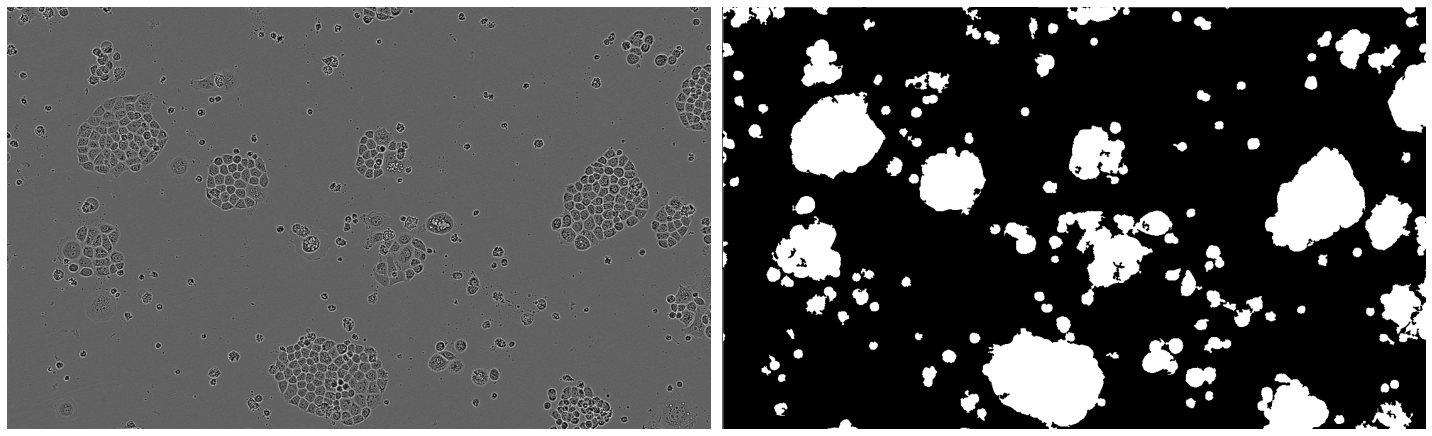

In [18]:
import cv2
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np
import skimage
im_path = '/projects/img/cellbank/duplicate_cells/CAMA1/batch_5/VID1341_A1_1_08d14h07m.jpg'
im_mask_path = '/projects/img/cellbank/duplicate_cells_masks/CAMA1/batch_5/VID1341_A1_1_08d14h07m.jpg'

img = skimage.io.imread(im_path)
mask = skimage.io.imread(im_mask_path,as_gray=True)


right = 224 * 5
bottom = 224 * 3

img = img[:bottom,:right]
mask = mask[:bottom,:right]

#thresh = skimage.filters.threshold_otsu(mask)
mask = mask > 127


transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=3),
    ])




f, axs = plt.subplots(1, 2,figsize=(20,15))


axs[0].imshow(img,cmap=plt.get_cmap('gray'))

axs[1].imshow(mask,cmap=plt.get_cmap('gray'))

for a in axs.flatten():
    a.axis('off')

f.tight_layout()

plt.show()

In [19]:
from einops import rearrange, reduce, repeat

cell_area_threshold = 0.05
patch_h,patch_w = 224,224
img_patches = rearrange(img, '(h p1) (w p2) c -> (h w) p1 p2 c', p1=patch_h, p2=patch_w)
mask_patches = rearrange(mask, '(h p1) (w p2) -> (h w) p1 p2', p1=patch_h, p2=patch_w)
selected_patches_id = []
# select patch where cell area >
for ids,mask_patch in enumerate(mask_patches):
     cell_area_percent = np.sum(mask_patch)/(patch_w*patch_h)
     if cell_area_percent >= cell_area_threshold:
         selected_patches_id.append(ids)
     else:
        print('Patch {} area ratio is {}'.format(ids,cell_area_percent))
        #plt.imshow(mask_patches[ids],cmap='gray')

if len(selected_patches_id) == 0:
    print('{} has no used patches!'.format(file_path))
    
selected_patches = [transform_test(im_p) for im_p in img_patches]
selected_patches = torch.stack(selected_patches)
# selected_patches = torch.permute(selected_patches,(0,3,1,2))

Patch 3 area ratio is 0.03513632015306122


In [21]:
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p, Evaluation
from Utils import utils




evaluate = True

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)


arch = 'Xception'
# resume = './OSR/classification/checkpoints/DATA_WELL_CV/{}_base{}/best_model.pth'.format(arch,10)

resume = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/checkpoints_patch/AZCell/Xception_patch224_area0.1_enhanced_auged/last_model.pth'

evaluate = True

train_class_num = 35
# Only for regression

print('==> Building model..')
#ResNet50
if 'ResNet' in arch:

    net = models.__dict__[arch](num_classes=train_class_num,backbone_fc=True,in_channel=3)

elif arch == 'Xception':
    net = models.xception_cla(num_class=train_class_num,input_channel=3)

# mobilenet_v2 vgg19_bn
else:
    net = torch_model.__dict__[arch](pretrained=False, num_classes=train_class_num)

criterion = nn.CrossEntropyLoss()
if device == 'cuda':
    #net = torch.nn.DataParallel(net)
    net = utils.DataParallel_withLoss(net,criterion,device_ids=list(range(torch.cuda.device_count())),output_device=0)
    cudnn.benchmark = True
net = net.module
if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
        
        
        

   

epoch=0
val_loss_pre = 9999999
if not evaluate:
    pass
else:
    net.eval()
    
    test_loss = 0
    correct = 0
    total = 0
    
    
    #print(net.module)
    # each list contain multiple batch data 
    
    predict_results =[]

    with torch.no_grad():
            
            
        inputs= selected_patches.cuda()
        #fake label defined here  
        class_labels = torch.tensor(len(inputs)*[10]).cuda()
        _, outputs = net(class_labels,inputs)
        #outputs = net(inputs)
        
        predict_results.append(outputs)
        
    predict_results = np.array(torch.cat(predict_results,dim=0).cpu().numpy())




cuda
==> Building model..
Multiple GPU [0].
==> Resuming from checkpoint..


Batch3 Image-level Prediction is NCI_H358


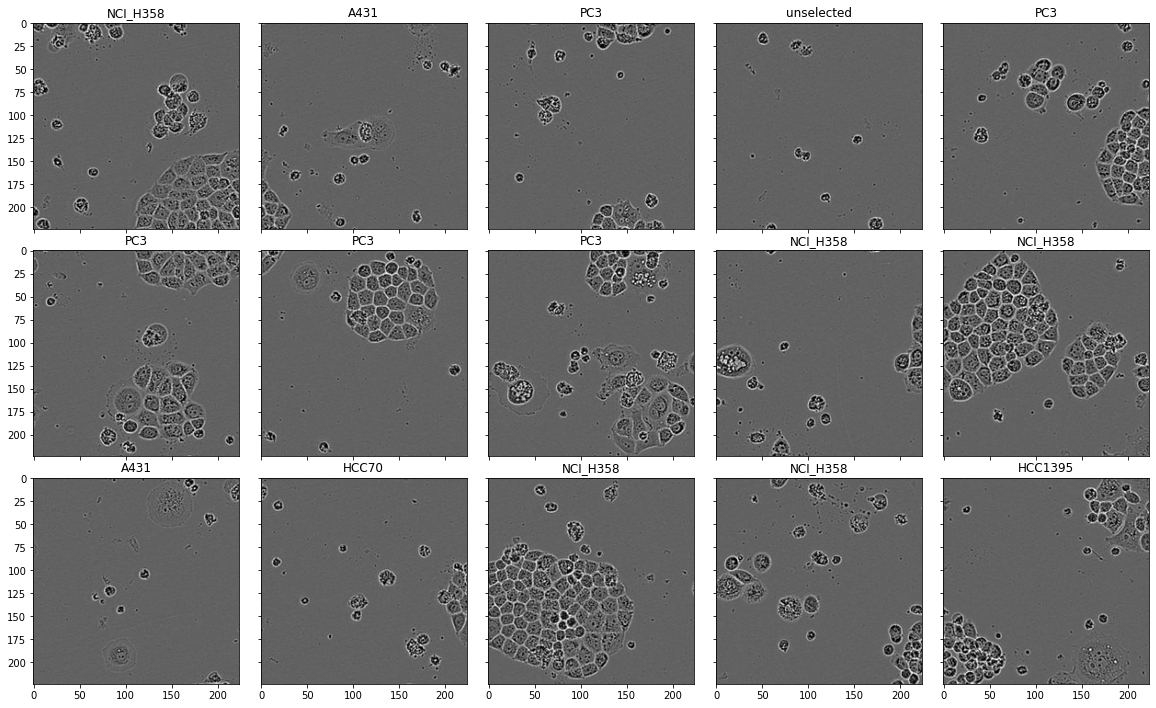

In [23]:
from sklearn.metrics import accuracy_score,f1_score

label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'

with open(label_id_path_file,'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
    
patch_labels = []
Image_level_label = []
for pred_id, patch_pred_proba in enumerate(predict_results):
    patch_pred = patch_pred_proba.argmax(axis=0)
    if pred_id in selected_patches_id:
        patch_labels.append(lines[patch_pred])
        Image_level_label.append(patch_pred)
        
    else:
        patch_labels.append('unselected')

Image_level_label = lines[np.argmax(np.bincount(Image_level_label))]
    
    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes
             )


for i, (ax, im) in enumerate(zip(grid, img_patches)):
    ax.imshow(im)
    ax.set_title('{}'.format(patch_labels[i]))
    
print('Batch3 Image-level Prediction is {}'.format(Image_level_label))    
plt.show()   
    


Image-level Prediction is NCI_H358


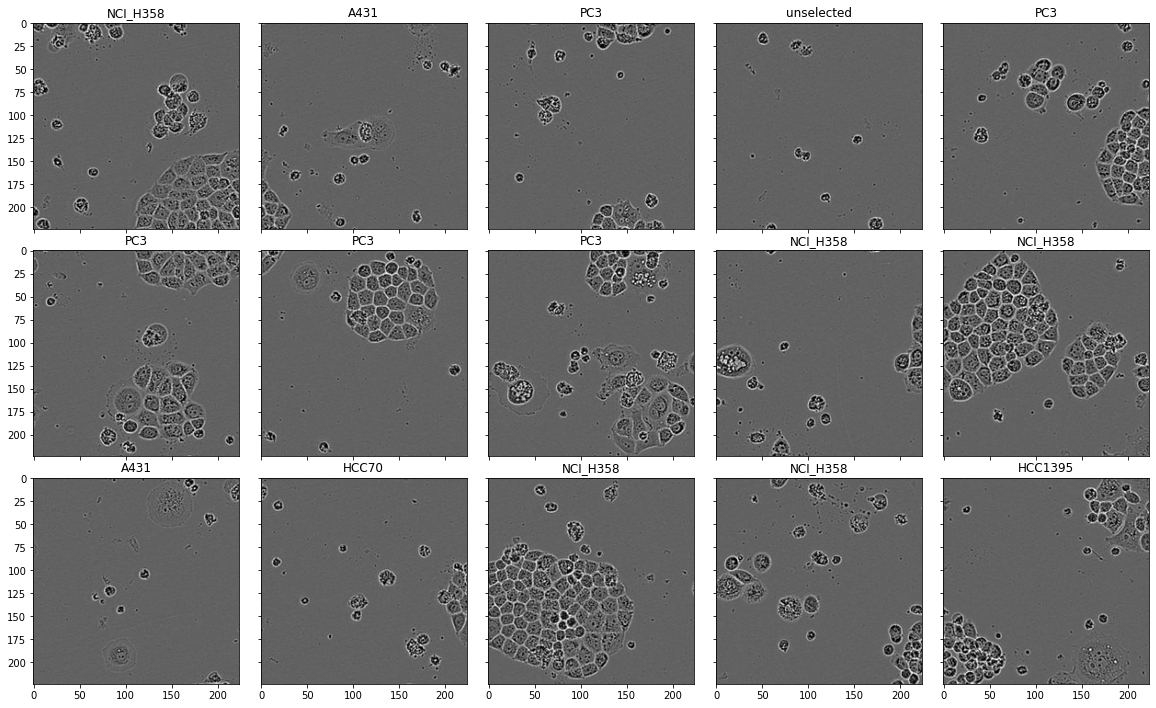

In [24]:
from sklearn.metrics import accuracy_score,f1_score

label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'

with open(label_id_path_file,'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]
    
patch_labels = []
Image_level_label = []
for pred_id, patch_pred_proba in enumerate(predict_results):
    patch_pred = patch_pred_proba.argmax(axis=0)
    if pred_id in selected_patches_id:
        patch_labels.append(lines[patch_pred])
        Image_level_label.append(patch_pred)
        
    else:
        patch_labels.append('unselected')

Image_level_label = lines[np.argmax(np.bincount(Image_level_label))]
    
    
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes
             )


for i, (ax, im) in enumerate(zip(grid, img_patches)):
    ax.imshow(im)
    ax.set_title('{}'.format(patch_labels[i]))
    
print('Image-level Prediction is {}'.format(Image_level_label))    
plt.show()   
    


In [ ]:
from PIL import Image
import cv2
import numpy as np
import torch
from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad
from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from torchvision.models import resnet50




methods = \
    {"gradcam": GradCAM,
     "scorecam": ScoreCAM,
     "gradcam++": GradCAMPlusPlus,
     "ablationcam": AblationCAM,
     "xgradcam": XGradCAM,
     "eigencam": EigenCAM,
     "eigengradcam": EigenGradCAM,
     "layercam": LayerCAM,
     "fullgrad": FullGrad}

model = net.model


target_layers = [net.model.exit_flow.conv]

rgb_img_transformed = img_patches

input_tensor = selected_patches

# If None, returns the map for the highest scoring category.
# Otherwise, targets the requested category.
target_category = 3
use_cuda= True
aug_smooth = True
eigen_smooth = True
# Using the with statement ensures the context is freed, and you can
# recreate different CAM objects in a loop.
cam_algorithm = methods["gradcam++"]

cam_patches = []

with cam_algorithm(model=model,
                   target_layers=target_layers,
                   use_cuda=use_cuda) as cam:

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 15

    grayscale_cam = cam(input_tensor=input_tensor,
                        target_category=target_category,
                        aug_smooth=aug_smooth,
                        eigen_smooth=eigen_smooth)
    
    
    
    
    
    for i,rgb_im in enumerate(rgb_img_transformed):
        cam_img = show_cam_on_image(rgb_im/255,grayscale_cam[i],use_rgb=True)
        #cam_img = cv2.cvtColor(cam_img, cv2.COLOR_RGB2BGR)
        cam_patches.append(cam_img)
    # Here grayscale_cam has only one image in the batch
#     grayscale_cam = grayscale_cam[0, :]
    
    #cam_image = show_cam_on_image(np.asarray(rgb_img_transformed)/255, grayscale_cam, use_rgb=True)


# #     cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

# gb_model = GuidedBackpropReLUModel(model=model, use_cuda=use_cuda)
# gb = gb_model(input_tensor, target_category=target_category)

# cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
# cam_gb = deprocess_image(cam_mask * gb)
# gb = deprocess_image(gb)

Image-level Prediction is NCI_H358


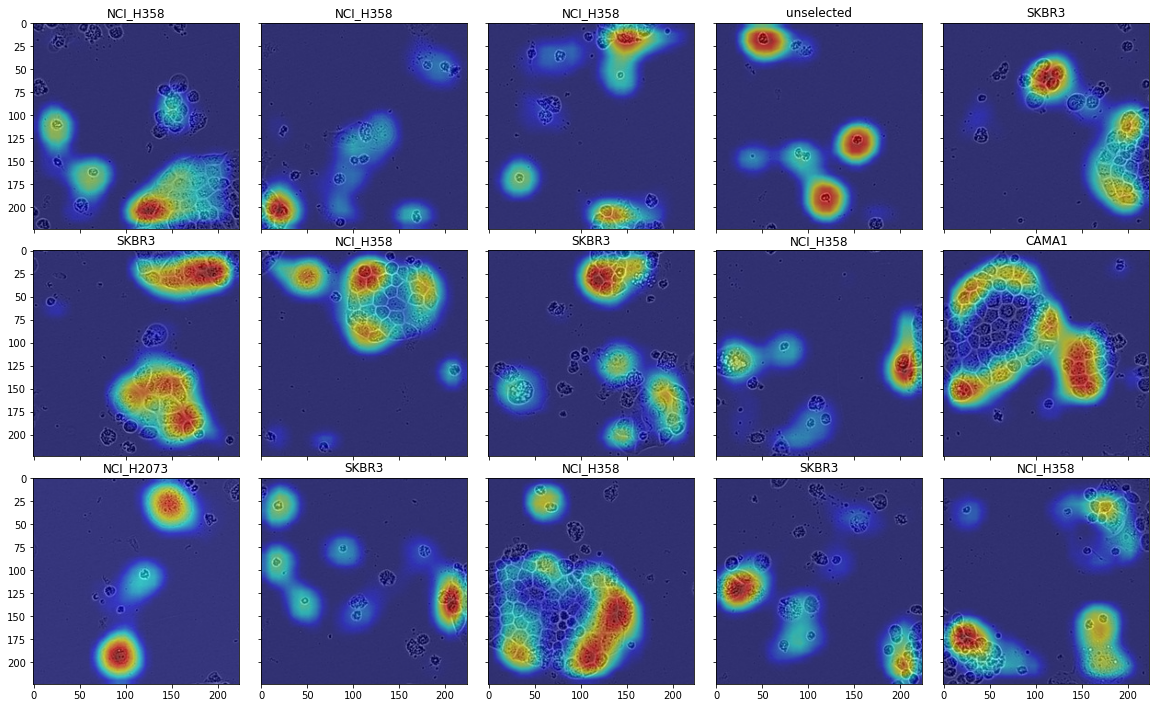

In [34]:

fig = plt.figure(figsize=(20., 20.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(3, 5),  # creates 2x2 grid of axes
                 axes_pad=0.3,  # pad between axes
             )


for i, (ax, im) in enumerate(zip(grid, cam_patches)):
    ax.imshow(im)
    ax.set_title('{}'.format(patch_labels[i]))
    
print('Image-level Prediction is {}'.format(Image_level_label))    
plt.show()   
    


# Patch numpy calculation

In [7]:
import numpy as np 
from natsort import natsorted
import os 
from scipy.special import softmax

patch_npy_root = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask/'
label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'


with open(label_id_path_file, 'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]

cell_folder_names = natsorted(lines)[:]

print('we have {} cell lines'.format(len(cell_folder_names)))

# cell_folder_names = ['MCF7']
patch_predictions,patch_labels = [],[]
img_preds, img_GT = [], [] 
batch_preds, batch_GT = [],[]
img_token,batch_token = 0,0



for class_ids, folder_name in enumerate(lines):
    batch_number = len(os.listdir(os.path.join(patch_npy_root, folder_name)))
    for i in range(2, 1+batch_number, 1):
        patch_representation_path = os.path.join(patch_npy_root, folder_name,'batch_{}'.format(i), "patch_predict_dino.npy")
        p_confluency_path = os.path.join(patch_npy_root, folder_name,'batch_{}'.format(i), "patches_confluency.npy")
        
        patch_representations = np.load(patch_representation_path,allow_pickle=True).item()
        p_confluency = np.load(p_confluency_path,allow_pickle=True).item()
        
        batch_imgs = []
        for key_name in patch_representations.keys():
            if p_confluency[key_name][0]['img_confluency']> 0:
            
                p_pred = []
                if len(patch_representations[key_name])>1:
                    for ri in patch_representations[key_name][:10]:
                        
                        p_prob = softmax(ri['prediction'])
                        p_pred.append(p_prob) 
                        patch_labels.append(class_ids)
                        
                    patch_predictions.extend(p_pred)
                    img_preds.append(np.mean(p_pred,axis=0))
                    batch_imgs.append(np.mean(p_pred,axis=0))
                    img_GT.append(class_ids)
            
            
        if len(batch_imgs) == 0:
            print(folder_name,i)
        batch_preds.append(np.mean(batch_imgs,axis=0))
        batch_GT.append(class_ids)
        


we have 36 cell lines


In [2]:
from sklearn.metrics import accuracy_score,f1_score, top_k_accuracy_score

p_accuracy = accuracy_score(patch_labels,patch_predictions)
p_f1_macro = f1_score(patch_labels,patch_predictions,average='weighted')
print(f"Patches accuracy is %.3f, f1 is %.3f"%(p_accuracy,p_f1_macro))

# img_Pred_results, img_GT = [],[]
# for img_id in np.unique(img_tokens):
#         imgs_ids = np.where(img_tokens == img_id)[0]
        
#         img_predicted_labels,img_labels =  patch_predictions[imgs_ids],labels_idx[imgs_ids]
#         img_predicted_labels,img_labels = np.argmax(np.bincount(img_predicted_labels)),np.argmax(np.bincount(img_labels))
#         img_Pred_results.append(img_predicted_labels)
#         img_GT.append(img_labels)
        
img_accuracy = accuracy_score(img_GT, img_preds)
img_f1_macro = f1_score(img_GT, img_preds,average='weighted')
print(f"Image accuracy is %.3f, f1 is %.3f"%(img_accuracy,img_f1_macro))
#print(f"Image top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(img_GT,img_preds,k=3,labels=range(35)),top_k_accuracy_score(img_GT,img_preds,k=5,labels=range(35))))

        
b_accuracy = accuracy_score( batch_GT,batch_preds)
b_f1_macro = f1_score(batch_GT,batch_preds,average='weighted')
print(f"Batch accuracy is %.3f, f1 is %.3f"%(b_accuracy,b_f1_macro))



ValueError: Classification metrics can't handle a mix of multiclass and continuous-multioutput targets

In [8]:
from sklearn.metrics import top_k_accuracy_score

class_num = len(lines)
print(f"patch top1=%.3f top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(patch_labels,patch_predictions,k=1,labels=range(class_num)),
                                                       top_k_accuracy_score(patch_labels,patch_predictions,k=3,labels=range(class_num)),top_k_accuracy_score(patch_labels,patch_predictions,k=5,labels=range(class_num))))

print(f"Image top1=%.3f top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(img_GT,img_preds,k=1,labels=range(class_num)),
                                                       top_k_accuracy_score(img_GT,img_preds,k=3,labels=range(class_num)),top_k_accuracy_score(img_GT,img_preds,k=5,labels=range(class_num))))

print(f"Flask top1=%.3f top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(batch_GT,batch_preds,k=1,labels=range(class_num)),
                                                       top_k_accuracy_score(batch_GT,batch_preds,k=3,labels=range(class_num)),top_k_accuracy_score(batch_GT,batch_preds,k=5,labels=range(class_num))))
        




patch top1=0.612 top3_acc=0.794, top5_acc=0.864
Image top1=0.716 top3_acc=0.868, top5_acc=0.920
Flask top1=0.822 top3_acc=1.000, top5_acc=1.000


In [92]:
from sklearn.metrics import confusion_matrix
import math
matrix = confusion_matrix(img_GT, np.argmax(img_preds,axis=1),labels=np.arange(0,36,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

for i in range(cm.shape[0]):
    if math.isnan(cm[i]) == False:
        print(lines[i], cm[i])
    

A431 1.0
A549 0.9960578186596584
CAMA1 0.8691709844559585
HCC2279 0.924496644295302
HCC78 1.0
HCC827 0.5540540540540541
HCT116 1.0
HELA 0.8853483286472977
HT1080 0.8345263157894737
Hop62 1.0
LU99 0.7280751708428246
MCF7 0.6578791469194313
MDA_MB_231 0.7198501872659177
Mia_Paca2 0.703125
MRC5 0.8690344062153164
NCI_H1975 0.9296962879640045
NCI_H2030 1.0
NCI_H2073 1.0
NCI_H358 1.0
U2OS 0.9617263843648208


/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [87]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(batch_GT,np.argmax(batch_preds,axis=1),labels=np.arange(0,35,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

batch_count = np.bincount(batch_GT)

for i in range(cm.shape[0]):
    
    if math.isnan(cm[i]) == False:
        print(lines[i], batch_count[i], cm[i])
    

A431 1 1.0
A549 3 1.0
CAMA1 4 0.75
HCC2279 1 1.0
HCC78 1 1.0
HCC827 1 0.0
HCT116 1 1.0
HELA 3 1.0
HT1080 3 1.0
Hop62 1 1.0
LU99 5 0.6
MCF7 6 0.6666666666666666
MDA_MB_231 2 0.5
Mia_Paca2 2 0.5
MRC5 2 1.0
NCI_H1975 4 1.0
NCI_H2030 1 1.0
NCI_H2073 2 1.0
NCI_H358 1 1.0


/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# Image Numpy Calculation

In [71]:
import numpy as np 
from natsort import natsorted
import os 
from scipy.special import softmax

patch_npy_root = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask/'
label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_40class_batch_idx.txt'


with open(label_id_path_file, 'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]

cell_folder_names = natsorted(lines)[:]

print('we have {} cell lines'.format(len(cell_folder_names)))

# cell_folder_names = ['MCF7']
patch_predictions,patch_labels = [],[]
img_preds, img_GT = [], [] 
batch_preds, batch_GT = [],[]
img_token,batch_token = 0,0


for class_ids, folder_name in enumerate(lines):
    batch_number = len(os.listdir(os.path.join(patch_npy_root, folder_name)))
    for i in range(2, 1+batch_number, 1):
        patch_representation_path = os.path.join(patch_npy_root, folder_name,'batch_{}'.format(i), "image_predict_dino.npy")
        p_confluency_path = os.path.join(patch_npy_root, folder_name,'batch_{}'.format(i), "patches_confluency.npy")
        
        patch_representations = np.load(patch_representation_path,allow_pickle=True).item()
        p_confluency = np.load(p_confluency_path,allow_pickle=True).item()
        
        batch_imgs = []
        for key_name in patch_representations.keys():
            if p_confluency[key_name][0]['img_confluency']> 0:
                batch_imgs.append(softmax(patch_representations[key_name]))
                img_preds.append(softmax(patch_representations[key_name]))
                img_GT.append(class_ids)
                
            
            
        if len(batch_imgs) == 0:
            print(folder_name,i)
        batch_preds.append(np.mean(batch_imgs,axis=0))
        batch_GT.append(class_ids)
        


we have 35 cell lines


In [72]:
from sklearn.metrics import top_k_accuracy_score


print(f"Image top1=%.3f top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(img_GT,img_preds,k=1,labels=range(35)),
                                                       top_k_accuracy_score(img_GT,img_preds,k=3,labels=range(35)),top_k_accuracy_score(img_GT,img_preds,k=5,labels=range(35))))

print(f"Flask top1=%.3f top3_acc=%.3f, top5_acc=%.3f"%(top_k_accuracy_score(batch_GT,batch_preds,k=1,labels=range(35)),
                                                       top_k_accuracy_score(batch_GT,batch_preds,k=3,labels=range(35)),top_k_accuracy_score(batch_GT,batch_preds,k=5,labels=range(35))))
        




Image top1=0.530 top3_acc=0.797, top5_acc=0.871
Flask top1=0.721 top3_acc=0.907, top5_acc=0.930


In [73]:
from sklearn.metrics import confusion_matrix
import math
matrix = confusion_matrix(img_GT, np.argmax(img_preds,axis=1),labels=np.arange(0,35,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

for i in range(cm.shape[0]):
    if math.isnan(cm[i]) == False:
        print(lines[i], cm[i])
    

A431 0.8227848101265823
A549 0.6040918880114861
CAMA1 0.4436502263521563
HCC2279 0.23626373626373626
HCC78 0.45614035087719296
HCC827 0.07181889149102264
HCT116 0.463768115942029
HELA 0.7844888366627497
HT1080 0.7707092582566324
Hop62 0.8938329430132709
LU99 0.5072503797817981
MCF7 0.3639067146658319
MDA_MB_231 0.5182767624020888
Mia_Paca2 0.06825619448340346
MRC5 0.016129032258064516
NCI_H1975 0.5465326633165829
NCI_H2030 1.0
NCI_H2073 0.5605442176870749
NCI_H358 0.9765441751368257


/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [70]:
from sklearn.metrics import confusion_matrix

matrix = confusion_matrix(batch_GT,np.argmax(batch_preds,axis=1),labels=np.arange(0,35,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

for i in range(cm.shape[0]):
    if math.isnan(cm[i]) == False:
        print(lines[i], cm[i])
    

A431 1.0
A549 1.0
CAMA1 0.75
HCC2279 0.0
HCC78 1.0
HCC827 0.0
HCT116 1.0
HELA 1.0
HT1080 1.0
Hop62 1.0
LU99 0.8
MCF7 0.6666666666666666
MDA_MB_231 0.5
Mia_Paca2 0.0
MRC5 0.0
NCI_H1975 1.0
NCI_H2030 1.0
NCI_H2073 1.0
NCI_H358 1.0


/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


In [49]:
import os 
import numpy as np
from natsort import natsorted
data_path = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask2'
npy_path = os.path.join(data_path, 'Mia_Paca2', 'batch_{}'.format(2),'patch_features.npy')
patch_dict = np.load(npy_path, allow_pickle=True).item()

sorted_img_names = natsorted(list(patch_dict.keys()))

sorted_img_names[11:20]

['Mia Paca2_A1_1_01d20h00m.jpg',
 'Mia Paca2_A1_1_02d00h00m.jpg',
 'Mia Paca2_A1_1_02d04h00m.jpg',
 'Mia Paca2_A1_1_02d08h00m.jpg',
 'Mia Paca2_A1_1_02d12h00m.jpg',
 'Mia Paca2_A1_1_02d16h00m.jpg',
 'Mia Paca2_A1_1_02d20h00m.jpg',
 'Mia Paca2_A1_1_03d00h00m.jpg',
 'Mia Paca2_A1_1_03d04h00m.jpg']

In [27]:
for name in sorted_img_names:
    a= []
    if len(patch_dict[name])<10:
        print(name)
    else:
        for pd in patch_dict[name]:
            a.append(pd['prediction'])
    np.array(a)
    

In [76]:
import math
batch_features=[]
for img_idx, img_name in enumerate(sorted_img_names):
    filename = img_name.split('.')[0]
    flask_position_name = filename.split('_')[1]
    # '00d12h00m'
    file_cTime = filename[-9:]
    # To hour-style ~
    label_time = (int(file_cTime[0:2]) * 24) + int(file_cTime[3:5])+math.ceil(float(file_cTime[6:8]) / 60)

    if len(patch_dict[img_name]) < 15:
        continue

    # features = self.feature_combine([r['features'] for r in patch_dict[img_name][:10]])
    patches_list = sorted(patch_dict[img_name], key=lambda i: i['confluency'])[::-1]

    #features = self.feature_combine([r['prediction'] for r in patches_list[:10]])
    features = [r['prediction'] for r in patches_list[:20]]
    
    batch_features.append(features)

In [77]:
np.array(batch_features).shape

/projects/img/cellbank/conda_envs/tensorflow_env/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  """Entry point for launching an IPython kernel.


(966,)

In [70]:
len(patch_dict['Mia Paca2_A1_1_02d00h00m.jpg'])


19

# MIL

In [27]:

from __future__ import print_function

import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
from torch.nn.functional import softmax
import numpy as np
import torchvision.transforms as transforms
import time
import os
import argparse
import sys

sys.path.append("../..")
from datasets import Cell_Sampling_new
import backbones.cell as cell_model
from Utils import adjust_learning_rate, progress_bar, Logger, mkdir_p,dataset_setting,balance_val_split
from Utils import utils
from sklearn.metrics import top_k_accuracy_score,f1_score,roc_auc_score

random_script_id =3
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch


# Data
print('==> Preparing data..')


transform_test = transforms.Compose([
    transforms.ToTensor(),
])

'''self-supverised learning features'''

data_path = '/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask2'
label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_32class_batch_idx.txt'


random_train_val = '/projects/img/cellbank/Cell_Batch_Classification/experiment_setup/batch_separated_32/random{}.txt'.format(random_script_id)
feature_combined_type = 'mean'
data_type = 'seq'


# train_set = Cell_Sampling_new.Cell_Features_sampling(data_path,label_id_path_file,train=True,
#                           transform=transform_test,feature_combined_type=feature_combined_type,data_type=data_type,random_train_val=random_train_val)

val_set  = Cell_Sampling_new.Cell_Features_sampling(data_path,label_id_path_file,train=False,
                         transform=transform_test,feature_combined_type=feature_combined_type,data_type=data_type,random_train_val=random_train_val)

==> Preparing data..


 97%|██████████████████████████████████████████████████████████████████████████████████████████   | 31/32 [00:54<00:01,  1.14s/it]

/projects/img/cellbank/Cell_Batch_Classification/enhanced_data_mask2/T47D/batch_1/patch_features.npy


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 32/32 [01:01<00:00,  1.93s/it]

Dataset includes 32 classes with 61 flasks 1329 samples.


In [28]:
# # For image
# image_seqs = val_set.sample_vectors
# new_seqs=[]
# for seq in image_seqs:
#     new_seqs.append(np.mean(seq,axis=0))
# new_seqs = np.concatenate(new_seqs)


# save_dic ={'labels':val_set.labels_idx,'features':new_seqs,'batch':val_set.batch_token}

# np.save('/projects/img/cellbank/Cell_Batch_Classification/experiments_stats/image_vit_seq.npy',save_dic)

In [29]:
def my_collate(batch):
    data = [item[0] for item in batch]
    target = [item[1] for item in batch]
    weights = [item[2] for item in batch]

    return [data,target,weights]

In [33]:
#trainloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=False, num_workers=0,collate_fn=my_collate)
valloader = torch.utils.data.DataLoader(val_set, batch_size=1, shuffle=False, num_workers=0,collate_fn=my_collate)
train_class_num = val_set.class_number


resume = './model/classification/experimental_models/batch_separated/random{}/CLANet_best_32cells_nossed/last_model.pth'.format(random_script_id)
#resume = './model/classification/experimental_models/batch_separated/random{}/gated_32cells/best_model.pth'.format(random_script_id)

net = cell_model.GatedAttention(train_class_num)

#net = net.to(device)

criterion = nn.CrossEntropyLoss(reduction='none')
net = utils.DataParallel_withLoss(net,criterion,device_ids=[0],output_device=0)

cudnn.benchmark = True
net = net.module

if resume:
    # Load checkpoint.
    if os.path.isfile(resume):

        print('==> Resuming from checkpoint..')
        # change here
        checkpoint = torch.load(resume)
        net.load_state_dict(checkpoint['net'])
        # best_acc = checkpoint['acc']
        # print("BEST_ACCURACY: "+str(best_acc))
        start_epoch = checkpoint['epoch']
        
    else:
        print("=> no checkpoint found at '{}'".format(resume))
        
        
        
        
net = net.model

Multiple GPU [0].
==> Resuming from checkpoint..


In [25]:

net.eval()

test_loss = 0
correct = 0
total = 0

#print(net.module)

batch_predict_results,class_labels,net_features,attention_weights =[],[],[],[]


scores, labels,A_weights = [], [],[]

with torch.no_grad():
    for batch_idx, (inputs, targets,_) in enumerate(valloader):
        inputs, targets = inputs[0].cuda(), targets[0].cuda()

        prob,M,A = net(inputs)
    

        scores.append(softmax(prob))
        labels.append(targets)
        A_weights.append(A.cpu().numpy().squeeze())
        net_features.append(M)
        
scores = np.array(torch.cat(scores, dim=0).cpu().numpy())
labels = np.array(torch.cat(labels, dim=0).cpu().numpy())
net_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
#A_weights = np.array(torch.cat(A_weights, dim=0).cpu().numpy())

In [98]:
a= np.where(labels==20)[0]
a

array([847, 848, 849, 850, 851, 852, 853, 854, 855, 856, 857, 858, 859,
       860, 861, 862, 863, 864, 865, 866, 867, 868, 869, 870, 871, 872,
       873, 874, 875, 876, 877, 878, 879, 880, 881, 882, 883, 884, 885,
       886, 887, 888])

In [99]:
np.argmax(scores,axis=1)[a]

array([27, 27, 27, 27, 27, 11, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27, 27,
       27, 27, 27, 27, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20, 20,
       20, 20, 20, 20, 20, 20, 20, 20])

In [140]:
ori_list = A_weights[879]
accumulated_list = []
for i in range(0,ori_list.shape[0],10):
    accumulated_list.append(sum(ori_list[i:i+10]))
np.argsort(accumulated_list)

array([12, 24, 18, 14, 15, 16, 21, 23, 10,  7, 20, 19,  8,  6,  9, 25, 34,
       11, 17,  5, 13,  3, 29, 31, 42, 37,  4, 46, 32, 33,  1, 35, 27, 22,
       28, 41,  0,  2, 26, 40, 38, 43, 44, 36, 39, 30, 45, 90, 47, 51, 48,
       49, 50, 52, 60, 55, 91, 87, 54, 86, 89, 84, 85, 82, 83, 53, 69, 74,
       65, 78, 71, 56, 68, 70, 72, 58, 88, 61, 63, 59, 67, 76, 73, 75, 64,
       80, 77, 79, 66, 62, 81, 57])

In [9]:
# save_dic ={'scores':scores,'labels':labels,'features':net_features,'batch':batch_token}

# np.save('/projects/img/cellbank/Cell_Batch_Classification/experiments_stats/CLANet_random3_data.npy',save_dic)

In [14]:

class_num = train_class_num
seq_top1_acc,seq_top3_acc,seq_top5_acc = top_k_accuracy_score(labels,scores,k=1,labels=range(class_num))\
                                        ,top_k_accuracy_score(labels,scores,k=3,labels=range(class_num))\
                                        ,top_k_accuracy_score(labels,scores,k=5,labels=range(class_num))

seq_f1 = f1_score(labels,np.argmax(scores,axis=1),average='macro')
seq_auc = roc_auc_score(labels,scores,multi_class='ovr')

print(seq_top1_acc,seq_f1)

batch_token = val_set.batch_token
b_scores, b_labels = [],[]
for batch_id in np.unique(batch_token):
    b_ids = np.where(batch_token == batch_id)[0]

    b_score, b_label = np.mean(scores[b_ids],axis=0), np.argmax(np.bincount(labels[b_ids]))
    
    b_scores.append(b_score)
    b_labels.append(b_label)

b_top1_acc, b_top3_acc, b_top5_acc = top_k_accuracy_score(b_labels, b_scores, k=1, labels=range(class_num)) \
                                    , top_k_accuracy_score(b_labels, b_scores, k=3, labels=range(class_num)) \
                                    , top_k_accuracy_score(b_labels, b_scores, k=5, labels=range(class_num))

b_f1 = f1_score(b_labels, np.argmax(b_scores, axis=1), average='macro')
b_auc = roc_auc_score(b_labels, b_scores, multi_class='ovr')

print(b_top1_acc,b_f1)

0.8600732600732601 0.7987396503049741
0.8524590163934426 0.8319805194805194


In [35]:
def eval_percent(percent_value):
    
    net.eval()

    test_loss = 0
    correct = 0
    total = 0

    #print(net.module)

    batch_predict_results,class_labels,net_features,attention_weights =[],[],[],[]


    scores, labels = [], []

    with torch.no_grad():
        for batch_idx, (inputs, targets,_) in enumerate(valloader):
            inputs, targets = inputs[0].cuda(), targets[0].cuda()
            seq_length = inputs.size()[0]
            new_seq_length = int(np.ceil(seq_length*percent_value))
        
            prob,M,A = net(inputs[:new_seq_length,:,:])
            # Inverse  seq length
            #prob,M,A = net(inputs[-new_seq_length:,:,:])


            scores.append(softmax(prob))
            labels.append(targets)

            net_features.append(M)

    scores = np.array(torch.cat(scores, dim=0).cpu().numpy())
    labels = np.array(torch.cat(labels, dim=0).cpu().numpy())
    net_features = np.array(torch.cat(net_features, dim=0).cpu().numpy())
    
    
    
    class_num = train_class_num
    seq_top1_acc,seq_top3_acc,seq_top5_acc = top_k_accuracy_score(labels,scores,k=1,labels=range(class_num))\
                                            ,top_k_accuracy_score(labels,scores,k=3,labels=range(class_num))\
                                            ,top_k_accuracy_score(labels,scores,k=5,labels=range(class_num))

    seq_f1 = f1_score(labels,np.argmax(scores,axis=1),average='macro')
    seq_auc = roc_auc_score(labels,scores,multi_class='ovr')

   

    batch_token = val_set.batch_token
    b_scores, b_labels = [],[]
    for batch_id in np.unique(batch_token):
        b_ids = np.where(batch_token == batch_id)[0]

        b_score, b_label = np.mean(scores[b_ids],axis=0), np.argmax(np.bincount(labels[b_ids]))

        b_scores.append(b_score)
        b_labels.append(b_label)

    b_top1_acc, b_top3_acc, b_top5_acc = top_k_accuracy_score(b_labels, b_scores, k=1, labels=range(class_num)) \
                                        , top_k_accuracy_score(b_labels, b_scores, k=3, labels=range(class_num)) \
                                        , top_k_accuracy_score(b_labels, b_scores, k=5, labels=range(class_num))

    b_f1 = f1_score(b_labels, np.argmax(b_scores, axis=1), average='macro')
    b_auc = roc_auc_score(b_labels, b_scores, multi_class='ovr')

    print('{}: percent:{:.4f},{:.4f}'.format(percent_value,seq_top1_acc,b_top1_acc))
    
    
for p in [0.01,0.25,0.50,0.75,1.0]:
    eval_percent(p)

0.01: percent:0.2521,0.3115
0.25: percent:0.6441,0.6557
0.5: percent:0.8239,0.8525
0.75: percent:0.8977,0.9180
1.0: percent:0.9112,0.9344


In [19]:
label_id_path_file = '/projects/img/cellbank/Cell_Batch_Classification/model/classification/train_32class_batch_idx.txt'

with open(label_id_path_file, 'r') as f:
    lines = f.readlines()
    lines = [line.rstrip() for line in lines]

In [89]:
a=np.where(np.array(b_labels)==20)[0]
a

array([40, 41])

In [90]:
np.argmax(b_scores,axis=1)[a]

array([11, 11])

In [6]:
from sklearn.metrics import confusion_matrix
import math
matrix = confusion_matrix(labels, np.argmax(scores,axis=1),labels=np.arange(0,32,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

for i in range(cm.shape[0]):
    if math.isnan(cm[i]) == False:
        print(cm[i])
        #print(lines[i],cm[i])
    

1.0
1.0
0.9365079365079365
0.5
0.6190476190476191
1.0
0.0
0.9855072463768116
0.9523809523809523
1.0
1.0
1.0
1.0
1.0
1.0
0.9682539682539683
0.9
0.7181818181818181
0.7647058823529411
0.9047619047619048
0.02127659574468085
0.9574468085106383
0.7727272727272727
0.9857142857142858
0.9615384615384616
1.0
1.0
1.0
1.0
1.0
0.1
1.0


In [7]:
from sklearn.metrics import confusion_matrix
import math
matrix = confusion_matrix(b_labels, np.argmax(b_scores,axis=1),labels=np.arange(0,32,1))

cm = matrix.diagonal()/matrix.sum(axis=1)

for i in range(cm.shape[0]):
    if math.isnan(cm[i]) == False:
        print(cm[i])
        #print(lines[i],cm[i])
    

1.0
1.0
1.0
0.5
1.0
1.0
0.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.8
0.8333333333333334
1.0
0.0
1.0
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
0.0
1.0


In [42]:
# -*- coding: utf-8 -*-
"""
plot a pretty confusion matrix with seaborn
Created on Mon Jun 25 14:17:37 2018
@author: Wagner Cipriano - wagnerbhbr - gmail - CEFETMG / MMC
REFerences:
  https://www.mathworks.com/help/nnet/ref/plotconfusion.html
  https://stackoverflow.com/questions/28200786/how-to-plot-scikit-learn-classification-report
  https://stackoverflow.com/questions/5821125/how-to-plot-confusion-matrix-with-string-axis-rather-than-integer-in-python
  https://www.programcreek.com/python/example/96197/seaborn.heatmap
  https://stackoverflow.com/questions/19233771/sklearn-plot-confusion-matrix-with-labels/31720054
  http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
"""

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn
from matplotlib.collections import QuadMesh


def get_new_fig(fn, figsize=[9, 9]):
    """Init graphics"""
    fig1 = plt.figure(fn, figsize)
    ax1 = fig1.gca()  # Get Current Axis
    ax1.cla()  # clear existing plot
    return fig1, ax1


def configcell_text_and_colors(
    array_df, lin, col, oText, facecolors, posi, fz, fmt, show_null_values=0
):
    """
    config cell text and colors
    and return text elements to add and to dell
    @TODO: use fmt
    """
    text_add = []
    text_del = []
    cell_val = array_df[lin][col]
    tot_all = array_df[-1][-1]
    per = (float(cell_val) / tot_all) * 100
    curr_column = array_df[:, col]
    ccl = len(curr_column)

    # last line  and/or last column
    if (col == (ccl - 1)) or (lin == (ccl - 1)):
        # tots and percents
        if cell_val != 0:
            if (col == ccl - 1) and (lin == ccl - 1):
                tot_rig = 0
                for i in range(array_df.shape[0] - 1):
                    tot_rig += array_df[i][i]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif col == ccl - 1:
                tot_rig = array_df[lin][lin]
                per_ok = (float(tot_rig) / cell_val) * 100
            elif lin == ccl - 1:
                tot_rig = array_df[col][col]
                per_ok = (float(tot_rig) / cell_val) * 100
            per_err = 100 - per_ok
        else:
            per_ok = per_err = 0

        per_ok_s = ["%.2f%%" % (per_ok), "100%"][per_ok == 100]

        # text to DEL
        text_del.append(oText)

        # text to ADD
        font_prop = fm.FontProperties(weight="bold", size=fz)
        text_kwargs = dict(
            color="w",
            ha="center",
            va="center",
            gid="sum",
            fontproperties=font_prop,
        )
        lis_txt = ["%d" % (cell_val), per_ok_s, "%.2f%%" % (per_err)]
        lis_kwa = [text_kwargs]
        dic = text_kwargs.copy()
        dic["color"] = "g"
        lis_kwa.append(dic)
        dic = text_kwargs.copy()
        dic["color"] = "r"
        lis_kwa.append(dic)
        lis_pos = [
            (oText._x, oText._y - 0.3),
            (oText._x, oText._y),
            (oText._x, oText._y + 0.3),
        ]
        for i in range(len(lis_txt)):
            newText = dict(
                x=lis_pos[i][0],
                y=lis_pos[i][1],
                text=lis_txt[i],
                kw=lis_kwa[i],
            )
            text_add.append(newText)

        # set background color for sum cells (last line and last column)
        carr = [0.27, 0.30, 0.27, 1.0]
        if (col == ccl - 1) and (lin == ccl - 1):
            carr = [0.17, 0.20, 0.17, 1.0]
        facecolors[posi] = carr

    else:
        if per > 0:
            txt = "%s\n%.2f%%" % (cell_val, per)
        else:
            if show_null_values == 0:
                txt = ""
            elif show_null_values == 1:
                txt = "0"
            else:
                txt = "0\n0.0%"
        oText.set_text(txt)

        # main diagonal
        if col == lin:
            # set color of the textin the diagonal to white
            oText.set_color("w")
            # set background color in the diagonal to blue
            facecolors[posi] = [0.35, 0.8, 0.55, 1.0]
        else:
            oText.set_color("r")

    return text_add, text_del


def insert_totals(df_cm):
    """insert total column and line (the last ones)"""
    sum_col = []
    for c in df_cm.columns:
        sum_col.append(df_cm[c].sum())
    sum_lin = []
    for item_line in df_cm.iterrows():
        sum_lin.append(item_line[1].sum())
    df_cm["sum_lin"] = sum_lin
    sum_col.append(np.sum(sum_lin))
    df_cm.loc["sum_col"] = sum_col


def pp_matrix(
    df_cm,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="y",
):
    """
    print conf matrix with default layout (like matlab)
    params:
      df_cm          dataframe (pandas) without totals
      annot          print text in each cell
      cmap           Oranges,Oranges_r,YlGnBu,Blues,RdBu, ... see:
      fz             fontsize
      lw             linewidth
      pred_val_axis  where to show the prediction values (x or y axis)
                      'col' or 'x': show predicted values in columns (x axis) instead lines
                      'lin' or 'y': show predicted values in lines   (y axis)
    """
    if pred_val_axis in ("col", "x"):
        xlbl = "Predicted"
        ylbl = "Actual"
    else:
        xlbl = "Actual"
        ylbl = "Predicted"
        df_cm = df_cm.T

    # create "Total" column
    insert_totals(df_cm)

    # this is for print allways in the same window
    fig, ax1 = get_new_fig("Conf matrix default", figsize)

    ax = sn.heatmap(
        df_cm,
        annot=annot,
        annot_kws={"size": fz},
        linewidths=lw,
        ax=ax1,
        cbar=cbar,
        cmap=cmap,
        linecolor="w",
        fmt=fmt,
    )

    # set ticklabels rotation
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, fontsize=10)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=25, fontsize=10)

    # Turn off all the ticks
    for t in ax.xaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)
    for t in ax.yaxis.get_major_ticks():
        t.tick1line.set_visible(False)
        t.tick2line.set_visible(False)

    # face colors list
    quadmesh = ax.findobj(QuadMesh)[0]
    facecolors = quadmesh.get_facecolors()

    # iter in text elements
    array_df = np.array(df_cm.to_records(index=False).tolist())
    text_add = []
    text_del = []
    posi = -1  # from left to right, bottom to top.
    for t in ax.collections[0].axes.texts:  # ax.texts:
        pos = np.array(t.get_position()) - [0.5, 0.5]
        lin = int(pos[1])
        col = int(pos[0])
        posi += 1

        # set text
        txt_res = configcell_text_and_colors(
            array_df, lin, col, t, facecolors, posi, fz, fmt, show_null_values
        )

        text_add.extend(txt_res[0])
        text_del.extend(txt_res[1])

    # remove the old ones
    for item in text_del:
        item.remove()
    # append the new ones
    for item in text_add:
        ax.text(item["x"], item["y"], item["text"], **item["kw"])

    # titles and legends
    
    ax.set_xlabel(xlbl)
    ax.set_ylabel(ylbl)
    plt.tight_layout()  # set layout slim
    plt.savefig('./experiments_stats/others/seq_cm_random2.png',dpi=300)
    plt.show()


def pp_matrix_from_data(
    y_test,
    predictions,
    columns=None,
    annot=True,
    cmap="Oranges",
    fmt=".2f",
    fz=11,
    lw=0.5,
    cbar=False,
    figsize=[8, 8],
    show_null_values=0,
    pred_val_axis="lin",
):
    """
    plot confusion matrix function with y_test (actual values) and predictions (predic),
    whitout a confusion matrix yet
    """
    from pandas import DataFrame
    from sklearn.metrics import confusion_matrix

    # data
    if not columns:
        from string import ascii_uppercase

        columns = [
            "class %s" % (i)
            for i in list(ascii_uppercase)[0 : len(np.unique(y_test))]
        ]

    confm = confusion_matrix(y_test, predictions)
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pp_matrix(
        df_cm,
        fz=fz,
        cmap=cmap,
        figsize=figsize,
        show_null_values=show_null_values,
        pred_val_axis=pred_val_axis,
    )


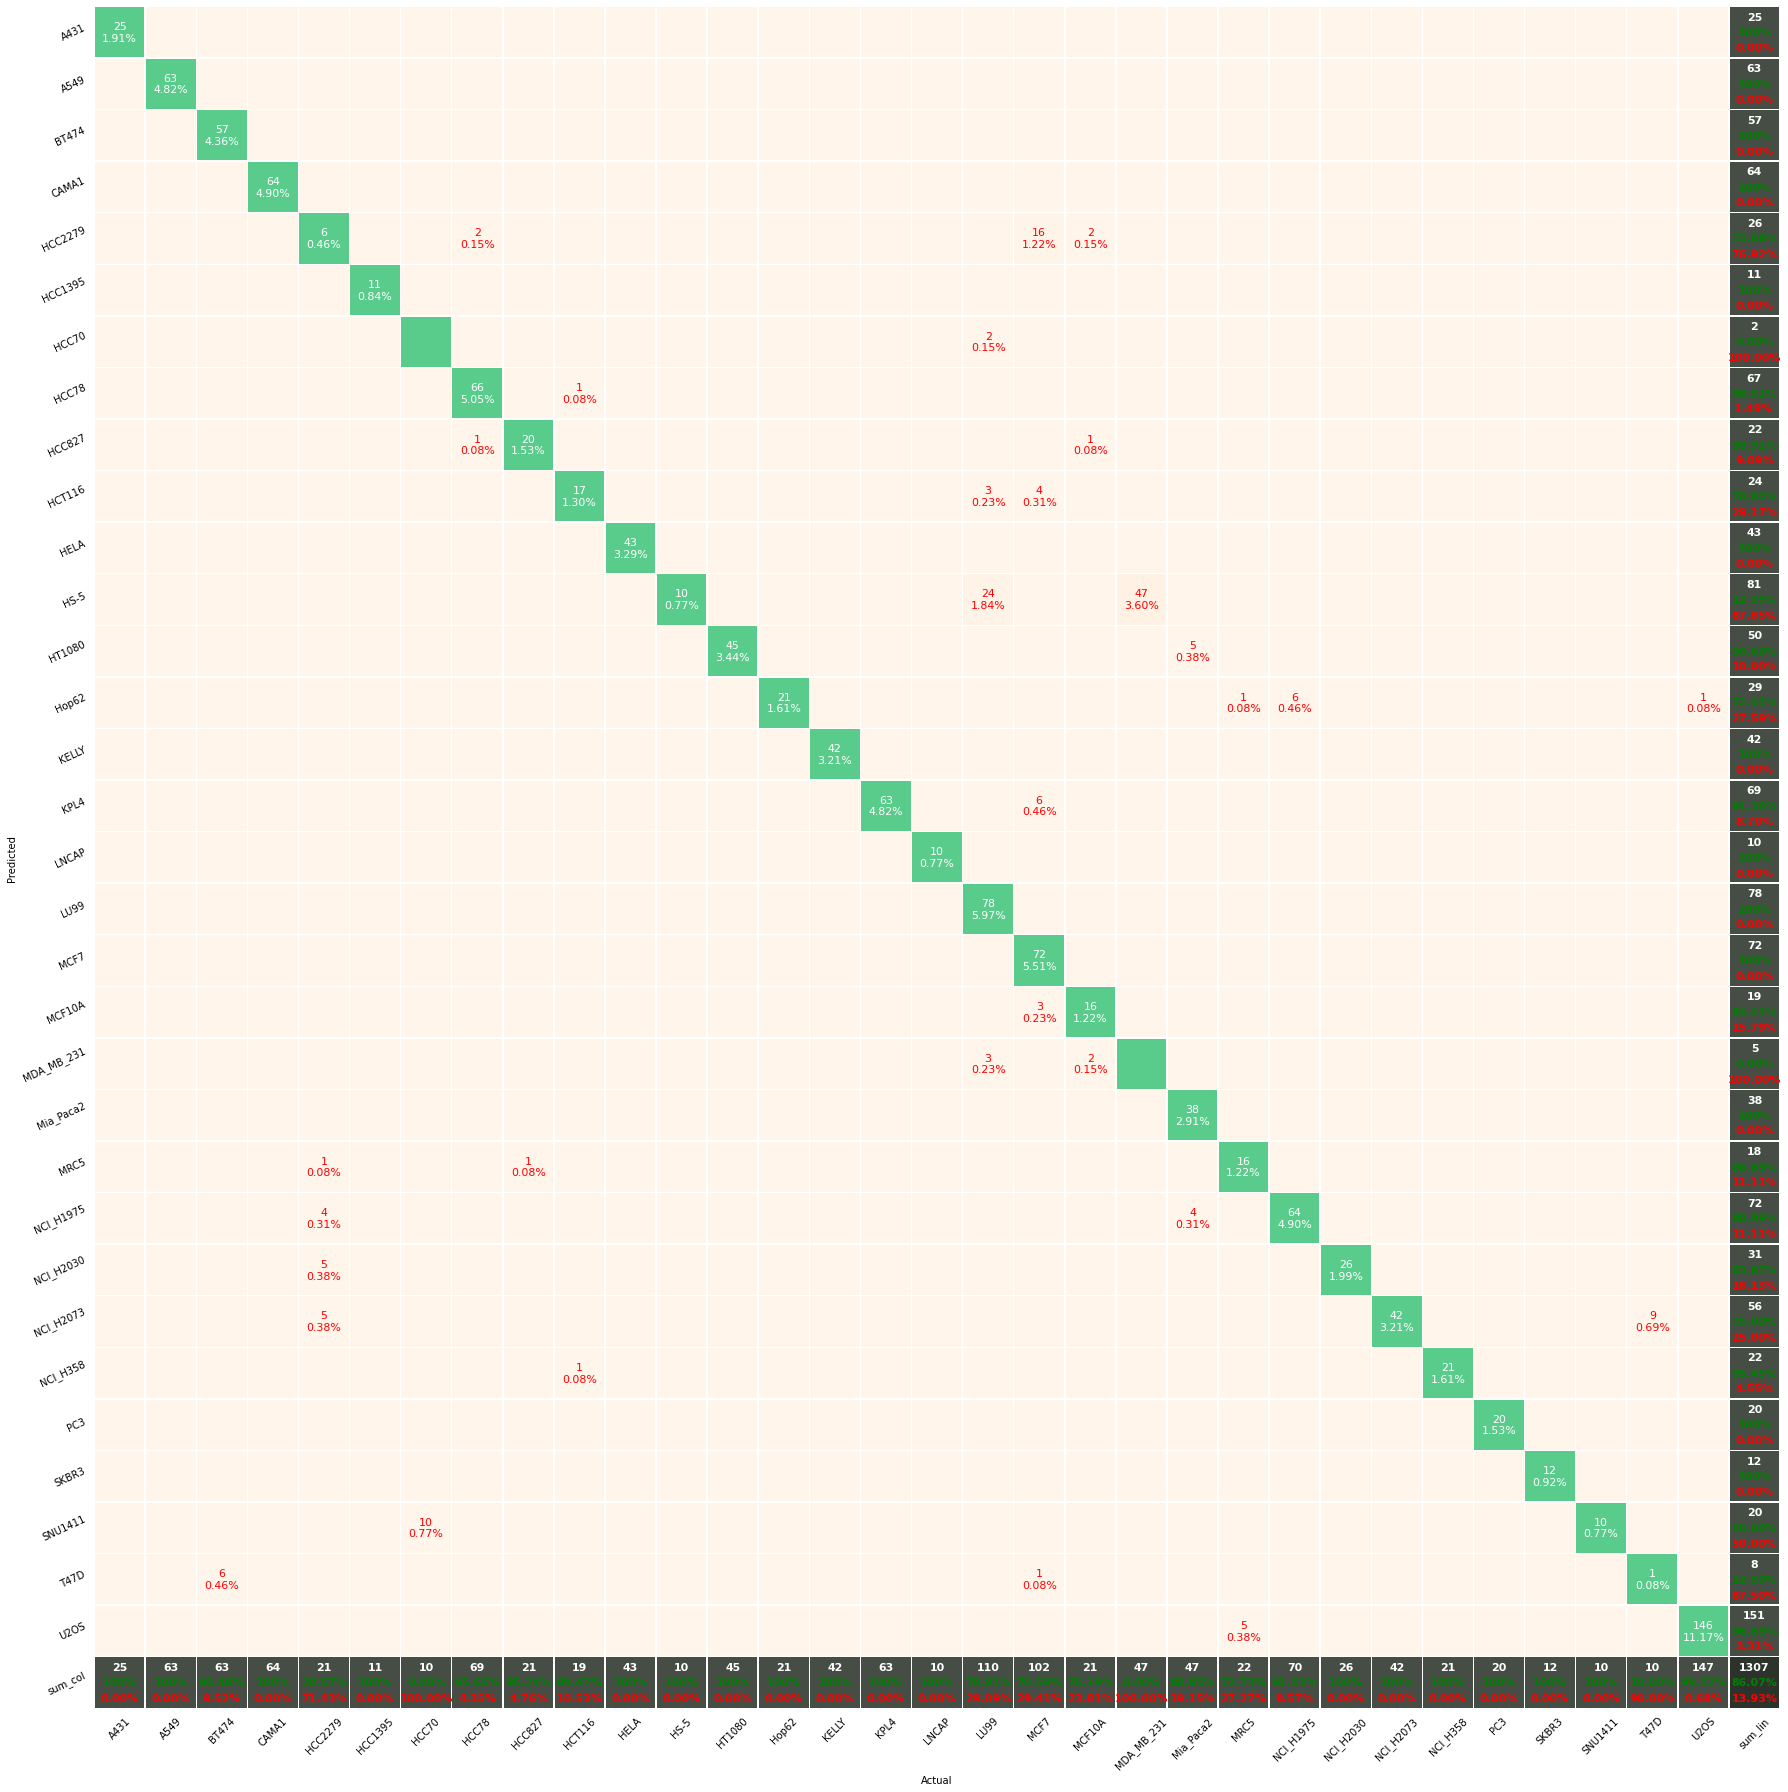

In [44]:
import numpy as np

pp_matrix_from_data(labels, np.argmax(scores,axis=1),columns=lines,figsize=[25,25])


# Classification Performance versus seg length

In [36]:
GAMIL =[[0.2396,0.2787,0.6352,0.6557,0.7912,0.7541,0.8286,0.8197,0.8601,0.8525],
[0.1614,0.1803,0.5241,0.6066,0.7460,0.7705,0.8087,0.7869,0.8447,0.8361],
[0.2596,0.2787,0.7096,0.7869,0.8480,0.8689,0.8947,0.8852,0.9074,0.9180]
]
GAMIL = np.array(GAMIL)

CLANet=[[0.1568,0.1803,0.5231,0.6230,0.7868,0.7705,0.8659,0.8525,0.8996,0.9016],
[0.1507,0.1311,0.4461,0.5410,0.7031,0.7705,0.8133,0.8197,0.8607,0.8852],
[0.2521,0.3115,0.6441,0.6557,0.8239,0.8525,0.8977,0.9180,0.9112,0.9344]
]
CLANet = np.array(CLANet)
CLANet.shape

(3, 10)

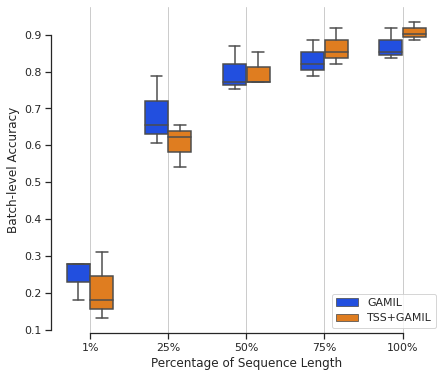

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

# Load the example planets dataset
planets = pd.DataFrame()
seq_index = [0,2,4,6,8]
batch_inex = [1,3,5,7,9]

planets['acc'] = np.concatenate((GAMIL[:,batch_inex].flatten(),CLANet[:,batch_inex].flatten()))
planets['seq_length'] = ['1%','25%','50%','75%','100%']*6
planets['Method'] = np.concatenate((['GAMIL']*15,['TSS+GAMIL']*15))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="seq_length", y="acc", hue='Method',data=planets,
            whis=[0, 100], width=.6, palette="bright",orient='v')

# # Add in points to show each observation
# sns.stripplot(x="acc", y="seq_length",hue='method' ,data=planets,
#               size=4, color=".3", linewidth=0)

plt.legend(loc = 'lower right')
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Batch-level Accuracy")
ax.set(xlabel="Percentage of Sequence Length")
sns.despine(trim=True)
plt.savefig('./experiments_stats/others/batch_bb.png',dpi=300)

In [43]:
# Inverse seq

GAMIL =[[0.6044,0.6230,0.7187,0.7213,0.8015,0.7869,0.8601,0.8525,0.8601,0.8525],
[0.6063,0.6129,0.6995,0.7097,0.7859,0.7742,0.8433,0.8387,0.8425,0.8548],
[0.5786,0.5738,0.6892,0.6885,0.7863,0.8361,0.9020,0.9180,0.9074,0.9180]
]
GAMIL = np.array(GAMIL)

CLANet=[[0.6601,0.6230,0.7575,0.7377,0.8513,0.8689,0.8974,0.9016,0.8996,0.9016],
[0.6886,0.7213,0.7544,0.7541,0.7850,0.8033,0.8493,0.8852,0.8607,0.8852],
[0.6245,0.6393,0.7600,0.8033,0.8224,0.8525,0.9022,0.9344,0.9112,0.9344],
]
CLANet = np.array(CLANet)
CLANet.shape

(3, 10)

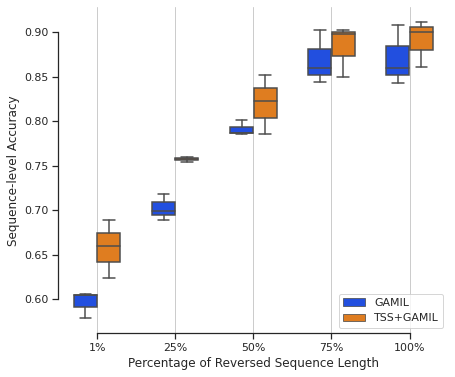

In [44]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
sns.set_theme(style="ticks")

# Initialize the figure with a logarithmic x axis
f, ax = plt.subplots(figsize=(7, 6))
#ax.set_xscale("log")

# Load the example planets dataset
planets = pd.DataFrame()
seq_index = [0,2,4,6,8]
batch_inex = [1,3,5,7,9]

planets['acc'] = np.concatenate((GAMIL[:,seq_index].flatten(),CLANet[:,seq_index].flatten()))
planets['seq_length'] = ['1%','25%','50%','75%','100%']*6
planets['Method'] = np.concatenate((['GAMIL']*15,['TSS+GAMIL']*15))
# Plot the orbital period with horizontal boxes
sns.boxplot(x="seq_length", y="acc", hue='Method',data=planets,
            whis=[0, 100], width=.6, palette="bright",orient='v')

# # Add in points to show each observation
# sns.stripplot(x="acc", y="seq_length",hue='method' ,data=planets,
#               size=4, color=".3", linewidth=0)

plt.legend(loc = 'lower right')
# Tweak the visual presentation
ax.xaxis.grid(True)
ax.set(ylabel="Sequence-level Accuracy")
ax.set(xlabel="Percentage of Reversed Sequence Length")
sns.despine(trim=True)
plt.savefig('./experiments_stats/others/reverse_seq_bb.png',dpi=300)